In [8]:
import eeg_lib
import os
from itertools import chain
import random
import numpy as np
import pandas as pd
import mne
import coffeine
import pyriemann
import itertools
import pickle
from sklearn.model_selection import train_test_split, PredefinedSplit

import pickle
import importlib

importlib.reload(eeg_lib)
from settings import EEGSettings
from eeg_lib import create_dataset, load_data, predict_lm, predict_lgbm, plot_clusters, merge_fig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import mne
import numpy as np
from itertools import compress

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm
from lightgbm import LGBMClassifier as lgbm

import pickle
import mne
import numpy as np
from itertools import compress

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm
from lightgbm import LGBMClassifier as lgbm

OSError: dlopen(/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [4]:
import os
import re
import glob
from dataclasses import field, dataclass, InitVar
from typing import List, Dict


@dataclass
class EEGSettings:
    """
    Settings for EEG postprocessing

    Constructor arguments:
        path: path to folder with subjects EEG
        channels_to_drop: names of channels to drop
        montage_name: name of EEG equipment montage
        events: names of events
        fr_bands: frequency bands for obtaining features
        dict_cls: indexes for pairwise classification
        files: paths to subject files (edf)
        mat_indexes: indexes of mat group subjects
        not_mat_indexes: indexes of not mat group subjects
        order_indexes: not_mat indexes after mat indexes
    """
    channels_to_drop: List[str] = field(default_factory=lambda: ['E8', 'E14', 'E17', 'E21', 'E25', 'E43', 'E44',
                                                                 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E65', 'E68',
                                                                 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E90',
                                                                 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114',
                                                                 'E119', 'E120', 'E125', 'E126', 'E127', 'E128',
                                                                 'Status'])
    montage_name: str = 'GSN-HydroCel-128'
    events: List[int] = field(default_factory=lambda: [241, 242, 244])
    fr_bands: Dict[str, List[int]] = field(default_factory=lambda: {'theta1': [4, 6],
                                                                    'theta2': [6, 8],
                                                                    'alpha1': [8, 10],
                                                                    'alpha2': [10, 12],
                                                                    'beta1': [12, 16],
                                                                    'beta2': [16, 20],
                                                                    'beta3': [20, 24]})
    dict_cls: Dict[str, List[int]] = field(default_factory=lambda: {'241/244': [0, 2],
                                                                    '242/244': [1, 2],
                                                                    '241/242': [0, 1]})
    subj_indexes: List[str] = field(default_factory=list)
    mat_indexes: List[str] = field(default_factory=lambda: ['311', '312', '314', '315', '316', '317', '326', '327',
                                                            '328', '330', '334', '335'])
    not_mat_indexes: List[str] = field(default_factory=list)
    files: Dict[str, List[str]] = field(default_factory=dict)
    path: InitVar[str] = ''

    def __post_init__(self, path):
        if path == '':
            raise ValueError('Please type path to EEG files folder')
        paths_to_subjects = [f for f in sorted(os.listdir(path))]
        _ = paths_to_subjects.pop(0)
        indexes = [re.search('(.+?)_', file_name).group(1) for file_name in paths_to_subjects]
        self.not_mat_indexes = [x for x in indexes if x not in self.mat_indexes]
        self.order_indexes = self.mat_indexes + self.not_mat_indexes
        paths_to_edf = [glob.glob(path + f'/{file_name}/Reals/*.edf') for file_name in paths_to_subjects]
        self.files = {key: value for key, value in zip(indexes, paths_to_edf)}

In [9]:
import mne

In [11]:
import random

In [12]:
# path to data
path = '/Users/ilyamikheev/Documents/IHNA/eeg_data'

save_folder = 'preprocessed_data'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# create settings object and initialise montage
settings = EEGSettings(path=path)
montage = mne.channels.make_standard_montage(settings.montage_name)

# subject indexes in both groups
mat_codes = settings.mat_indexes
not_mat_codes = settings.not_mat_indexes
all_codes = settings.order_indexes
index_mat, index_not_mat = [all_codes.index(i) for i in mat_codes], [all_codes.index(i) for i in not_mat_codes]
index_all = index_mat + index_not_mat

# for cross validation
new_mat, new_not_mat = random.sample(mat_codes, 10), random.sample(not_mat_codes, 10)
index_new_mat, index_new_not_mat = [all_codes.index(i) for i in new_mat], [all_codes.index(i) for i in new_not_mat]
index_all_new = index_new_mat + index_new_not_mat

# success and no success subjects
suc_subj = ['311', '316', '312', '334', '313', '332', '324', '337']
not_suc_subj = ['314', '327', '326', '335', '329', '319', '318', '320']

<center><b>Create feature space</b></center>

In [ ]:
# create dataset and save on disc
data = create_dataset(settings, montage)

In [4]:
# load from local data
data = load_data(['chan_names', 'info_object'])

Loading of files: 100%|██████████| 2/2 [00:00<00:00, 276.59it/s]


In [7]:
data = load_data(['chan_names', 'info_object', 'spectra_feat'])

Loading of files: 100%|██████████| 3/3 [00:00<00:00, 26.84it/s]


In [220]:
import itertools

for i, j in itertools.product(range(26), range(3)):
    if not os.path.exists(f'{save_folder}/ind_data/{i}'):
        os.makedirs(f'{save_folder}/ind_data/{i}')
    with open(f'{save_folder}/ind_data/{i}/{j}.pkl', 'wb') as file:
        pickle.dump(data['raw_epochs'][i][j], file)

KeyError: 'raw_epochs'

In [ ]:
import pyriemann
import itertools

cov_l = []
for i, j, m in tqdm(itertools.product(range(26), range(3), range(7)), total=546):
    with open(f'{save_folder}/ind_data/{i}/{j}.pkl', 'rb') as file:
        d = pickle.load(file)
    cov = pyriemann.utils.covariance.covariances(
        d.filter(*list(settings.fr_bands.values())[m], verbose=False).get_data(), estimator='oas')
    cov_l.append(cov)


In [ ]:
фФ

In [ ]:
with open(f'{save_folder}/cov_a.pkl', 'wb') as file:
    pickle.dump(col_ll2, file)

In [5]:
with open(f'{save_folder}/cov_a.pkl', 'rb') as file:
    col_ll2 = pickle.load(file)

In [ ]:
col_ll2

In [ ]:
def predict_lm(data, eeg_param, ps=None):
    """
    function for logistic regression model
    Parameters
    ----------
    data: list[np.ndarray]
    eeg_param: list[dict, list]
       [fr_bands, channels_names]

    Returns
    -------
    :rtype: tuple
    :return: ac, roc_auc, interp_tpr, coefs
    """
    mean_fpr = np.linspace(0, 1, 100)
    coefs = np.zeros((2, len(eeg_param[0]), len(eeg_param[1])))
    model = make_pipeline(StandardScaler(),
                          LinearModel(LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), penalty='l2',
                                                           scoring='roc_auc', random_state=0, max_iter=10000,
                                                           fit_intercept=True, solver='newton-cg', cv=ps,
                                                           class_weight='balanced', tol=10)))
    model.fit(data[0], data[2])
    y_predict, y_predict_pr = model.predict(data[1]), model.predict_proba(data[1])
    ac = balanced_accuracy_score(data[3], y_predict)
    fpr, tpr, _ = roc_curve(data[3], y_predict_pr[:, 1])
    roc_auc, interp_tpr = auc(fpr, tpr), np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return ac, roc_auc, interp_tpr, y_predict_pr


In [ ]:
[i for i in range(0, 51, 5)][1:]

In [ ]:
import transformers

importlib.reload(transformers)
from transformers import CSP

In [ ]:
import transformers
importlib.reload(transformers)
CSP = transformers.CSP
CSPCv = transformers.CSPCv

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class ScalerCSP(BaseEstimator, TransformerMixin):
    def __init__(self, nfilter=5):
        self.csp_f_ = None
        self.nfilter = nfilter

    def fit(self, x_train, y_train):
        csp = pyriemann.spatialfilters.CSP(nfilter=self.nfilter, metric='riemann', log=True)
        self.csp_f_ = [csp.fit(x_train[:, n, ...], y_train) for n in range(7)]
        return self

    def transform(self, x_test):
        l = len(x_test)
        x = np.stack([self.csp_f_[n].transform(x_test[:, n]) for n in range(7)], axis=1).reshape(l, -1)
        return x

In [ ]:
from sklearn.linear_model import LogisticRegression

results = np.zeros((len(index_new_mat), len(settings.dict_cls), 2))
coefs = np.zeros((len(index_new_mat), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_new_mat, index_new_not_mat)), total=len(index_new_mat),
                                      desc=f'Evaluation for {len(index_new_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for ind in tqdm(range(3), total=3, position=1):
        # subjects for cv
        s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_new_mat if i != s_ind_1]), random.choice(
            [i for i in index_new_not_mat if i != s_ind_2])
        y_train = [1] * sum([col_ll2[i][ind][0].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [
            0] * sum([col_ll2[i][ind][0].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
        x_train = [col_ll2[i][ind] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]]
        x_train = np.concatenate([np.stack(x_train[i]) for i in range(len(x_train))], axis=1).transpose(1, 0, 2, 3)
        csp_l = [CSPCv(metric='euclid', log=True) for n in range(7)]
        f = [csp_l[n].fit(x_train[:, n, ...], y_train).filters_ for n in range(7)]
        p = [csp_l[n].fit(x_train[:, n, ...], y_train).patterns_ for n in range(7)]
        y_val = [1] * col_ll2[s_ind_1_cv][ind][0].shape[0] + [0] * col_ll2[s_ind_2_cv][ind][0].shape[0]
        x_val = [col_ll2[i][ind] for i in [s_ind_1_cv, s_ind_2_cv]]
        x_val = np.concatenate([np.stack(x_val[i]) for i in range(len(x_val))], axis=1).transpose(1, 0, 2, 3)
        y_test = [1] * col_ll2[s_ind_1][ind][0].shape[0] + [0] * col_ll2[s_ind_2][ind][0].shape[0]
        x_test = [col_ll2[i][ind] for i in [s_ind_1, s_ind_2]]
        x_test = np.concatenate([np.stack(x_test[i]) for i in range(len(x_test))], axis=1).transpose(1, 0, 2, 3)
        ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
        x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val

        pipe = Pipeline(steps=[('csp', CSP(csp_f=f)), ('scaler', StandardScaler()), ('logistic',
                                                                                LogisticRegression(penalty='l2',
                                                                                 random_state=0,
                                                                                 max_iter=10000,
                                                                                 fit_intercept=True,
                                                                                 solver='newton-cg', class_weight='balanced',
                                                                                                            tol=10))])
        param_grid = {
            'csp__nfilter': [5],
            "logistic__C": [0.001]}
        search = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=ps, n_jobs=2, verbose=10)
        search.fit(x_train, y_train)
        y_predict, y_predict_pr = search.predict(x_test), search.predict_proba(x_test)
        ac = balanced_accuracy_score(y_test, y_predict)
        fpr, tpr, _ = roc_curve(y_test, y_predict_pr[:, 1])
        mean_fpr = np.linspace(0, 1, 100)
        roc_auc, interp_tpr = auc(fpr, tpr), np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        results[count, ind, ...] = ac, roc_auc
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

In [ ]:
results[:,2,0].mean()

In [ ]:
metrics_d = {}
anova_d = {}

In [ ]:
anova_d['log_reg_csp'] = results
metrics_d['log_reg_csp'] = metrics

In [ ]:

metrics_d['log_reg_csp'] = metrics

In [ ]:
{'csp__nfilter': [2, 5, 10],
"logistic__C": list(np.power(10.0, np.arange(-5, 5)))}

In [ ]:
import transformers
importlib.reload(transformers)
CSP = transformers.CSP
PCS = transformers.PCS
pjcs = transformers.ProjCommonSpaceCV

In [ ]:
from sklearn.linear_model import LogisticRegression

results = np.zeros((len(index_new_mat), len(settings.dict_cls), 2))
coefs = np.zeros((len(index_new_mat), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_new_mat, index_new_not_mat)), total=len(index_new_mat),
                                      desc=f'Evaluation for {len(index_new_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for ind in tqdm(range(3), total=3, position=1):
        # subjects for cv
        s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_new_mat if i != s_ind_1]), random.choice(
            [i for i in index_new_not_mat if i != s_ind_2])
        y_train = [1] * sum([col_ll2[i][ind][0].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [
            0] * sum([col_ll2[i][ind][0].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
        x_train = [col_ll2[i][ind] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]]
        x_train = np.concatenate([np.stack(x_train[i]) for i in range(len(x_train))], axis=1).transpose(1, 0, 2, 3)
        csp_l = [pjcs(scale='auto', n_compo=10, reg=1e-7) for n in range(7)]
        f = [csp_l[n].fit(x_train[:, n, ...], y_train).filters_ for n in range(7)]
        p = [csp_l[n].fit(x_train[:, n, ...], y_train).patterns_ for n in range(7)]
        y_val = [1] * col_ll2[s_ind_1_cv][ind][0].shape[0] + [0] * col_ll2[s_ind_2_cv][ind][0].shape[0]
        x_val = [col_ll2[i][ind] for i in [s_ind_1_cv, s_ind_2_cv]]
        x_val = np.concatenate([np.stack(x_val[i]) for i in range(len(x_val))], axis=1).transpose(1, 0, 2, 3)
        y_test = [1] * col_ll2[s_ind_1][ind][0].shape[0] + [0] * col_ll2[s_ind_2][ind][0].shape[0]
        x_test = [col_ll2[i][ind] for i in [s_ind_1, s_ind_2]]
        x_test = np.concatenate([np.stack(x_test[i]) for i in range(len(x_test))], axis=1).transpose(1, 0, 2, 3)
        ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
        x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
        ts = pyriemann.tangentspace.TangentSpace()
        pipe = Pipeline(steps=[('pcs', PCS(filters=f)), ('scaler', StandardScaler()), ('logistic',
                                                                                LogisticRegression(penalty='l2',
                                                                                 random_state=0,
                                                                                 max_iter=10000,
                                                                                 fit_intercept=True,
                                                                                 solver='newton-cg', class_weight='balanced',
                                                                                                            tol=10))])
        param_grid = {
            'pcs__ncompo': [45],
            'logistic__C': [0.001] }
        search = GridSearchCV(pipe, param_grid, scoring='balanced_accuracy', cv=ps, n_jobs=1, verbose=10)
        search.fit(x_train, y_train)
        y_predict, y_predict_pr = search.predict(x_test), search.predict_proba(x_test)
        ac = balanced_accuracy_score(y_test, y_predict)
        fpr, tpr, _ = roc_curve(y_test, y_predict_pr[:, 1])
        mean_fpr = np.linspace(0, 1, 100)
        roc_auc, interp_tpr = auc(fpr, tpr), np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        results[count, ind, ...] = ac, roc_auc
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

In [ ]:
metrics

In [ ]:
def plot_roc_curves(tprs, aucs, list_predictions, list_y_true, plot_all=True, ax=None):
    """
    function that plot roc curves
    Parameters
    ----------
    tprs: list[float]
    aucs: list[float]
    list_predictions: list[np.ndarray[float]]
        predictions
    list_y_true: list[list[int]]
        true target values
    plot_all: bool
        Plot or not to plot roc for each fold. Default True
    ax:
    Returns
    -------
    :rtype:matplotlib.figure.Figure
    """
    mean_fpr, ret, fig = np.linspace(0, 1, 100), False, None
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ret = True
    if plot_all:
        for i, (y_true, pred) in enumerate(zip(list_y_true, list_predictions)):
            RocCurveDisplay.from_predictions(y_true=y_true, y_pred=pred[:, 1].tolist(), name=f"ROC fold {i + 1}", ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc, std_auc = auc(mean_fpr, mean_tpr), np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper, tprs_lower = np.minimum(mean_tpr + std_tpr, 1), np.maximum(mean_tpr - std_tpr, 0)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} \u00B1 {std_auc:.2f})', lw=2,
            alpha=0.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='\u00B1  1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.tick_params(axis='both', labelsize=65)
    ax.set_xlabel('True Positive Rate', fontsize=70)
    ax.set_ylabel('False Positive Rate', fontsize=70)
    ax.legend(loc='lower right', fontsize=55)
    if ret:
        return fig
    else:
        pass

if alg == a_1

In [ ]:
anova_d['log_reg_r'] = results
metrics_d['log_reg_r'] = metrics

In [ ]:
search.cv_results_

In [ ]:
search.cv_results_

In [ ]:
results[:,0,0].mean()

In [ ]:
'logistic__C': list(np.power(10.0, np.arange(-3, 0)))}

In [ ]:
index_new_not_mat

In [ ]:
index_new_mat

In [ ]:
metrics_d = {}
anova_d = {}

In [ ]:
# save results
with open('Results/res_dict_f.pkl', 'wb') as f:
    pickle.dump(anova_d, f)

with open('Results/m_dict_f.pkl', 'wb') as f:
    pickle.dump(metrics_d, f)

In [ ]:
with open('Results/m_dict_f.pkl', 'wb') as f:
    pickle.dump(metrics_d, f)

In [ ]:
with open('Results/matf.pkl', 'wb') as f:
    pickle.dump(index_new_mat, f)

with open('Results/not_matf.pkl', 'wb') as f:
    pickle.dump(index_new_not_mat, f)

In [ ]:
metrics_d['log_reg_gr_t']

In [ ]:
with open('Results/mat.pkl', 'wb') as f:
    pickle.dump(index_new_mat, f)

with open('Results/not_mat.pkl', 'wb') as f:
    pickle.dump(index_new_not_mat, f)

In [ ]:
index_new_mat

In [ ]:
index_new_not_mat

In [8]:
with open('Results/matf.pkl', 'rb') as f:
    index_new_mat = pickle.load(f)
with open('Results/not_matf.pkl', 'rb') as f:
     index_new_not_mat = pickle.load(f)

In [15]:
with open('Results/res_dict_f.pkl', 'rb') as f:
    anova_d = pickle.load(f)

In [18]:
anova_d['log_reg_r']

array([[[0.77634011, 1.        ],
        [0.9967462 , 0.99999087],
        [0.99069767, 0.99994056]],

       [[0.85065521, 0.97045797],
        [0.87202797, 0.99466817],
        [0.87751371, 0.99661631]],

       [[0.81775701, 1.        ],
        [0.90366803, 0.98981934],
        [0.90983171, 0.97218495]],

       [[0.9979716 , 1.        ],
        [1.        , 1.        ],
        [0.97775801, 1.        ]],

       [[1.        , 1.        ],
        [0.9843342 , 1.        ],
        [0.95048309, 1.        ]],

       [[1.        , 1.        ],
        [0.99864499, 1.        ],
        [0.9983871 , 1.        ]],

       [[0.77838828, 0.99171532],
        [0.82411067, 0.99193498],
        [0.81584399, 0.92790512]],

       [[0.74668367, 0.76492347],
        [0.35772959, 0.341     ],
        [0.30806664, 0.26144285]],

       [[1.        , 1.        ],
        [1.        , 1.        ],
        [1.        , 1.        ]],

       [[0.84911603, 0.97057509],
        [0.88573542, 0.9731084

In [12]:
metrics_dkeys()

dict_keys(['log_reg_csp', 'log_reg_r', 'lgbm_gr'])

In [ ]:
'lgbm_gr'

TypeError: list indices must be integers or slices, not tuple

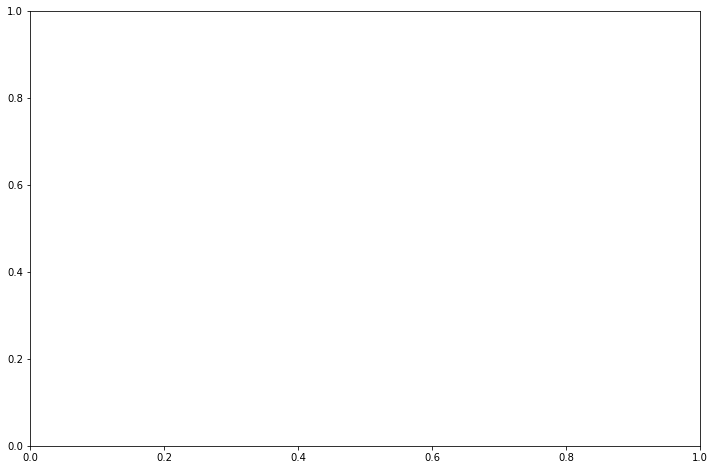

In [229]:
plot_roc_curves(metrics_d['log_reg_r']['tprs'], metrics_d['log_reg_r']['aucs'], metrics_d['log_reg_r']['pr_v'], metrics_d['log_reg_r']['true_v'])

In [222]:
metrics_d.keys()

dict_keys(['log_reg_csp', 'log_reg_r', 'lgbm_gr'])

In [ ]:
'log_reg_csp'

In [240]:
metrics_d['log_reg_csp']

{'tprs': [[array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
   array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
   array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [231]:
s_ind

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(40, 60))
s_ind = [i for i in range(10)]
subfigs = fig.subfigures(1, 1, wspace=0.07)
axs_right = subfigs.subfigures(3, 1)
for n, (ax, name) in enumerate(zip(axs_right, ['D', 'E', 'F'])):
    ax = ax.subplots(nrows=1, ncols=1)
plot_roc_curves([metrics_d['log_reg_сsp']['tprs'][i][n] for i in s_ind],
                [metrics_d['log_reg_csp']['aucs'][i][n] for i in s_ind],
                [metrics_d['log_reg_csp']['pr_v'][i][n] for i in s_ind],
                [metrics_d['log_reg_csp']['true_v'][i][n] for i in s_ind], plot_all=False, ax=ax)

In [242]:
metrics_d['log_reg_csp']

{'tprs': [[array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
   array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
   array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

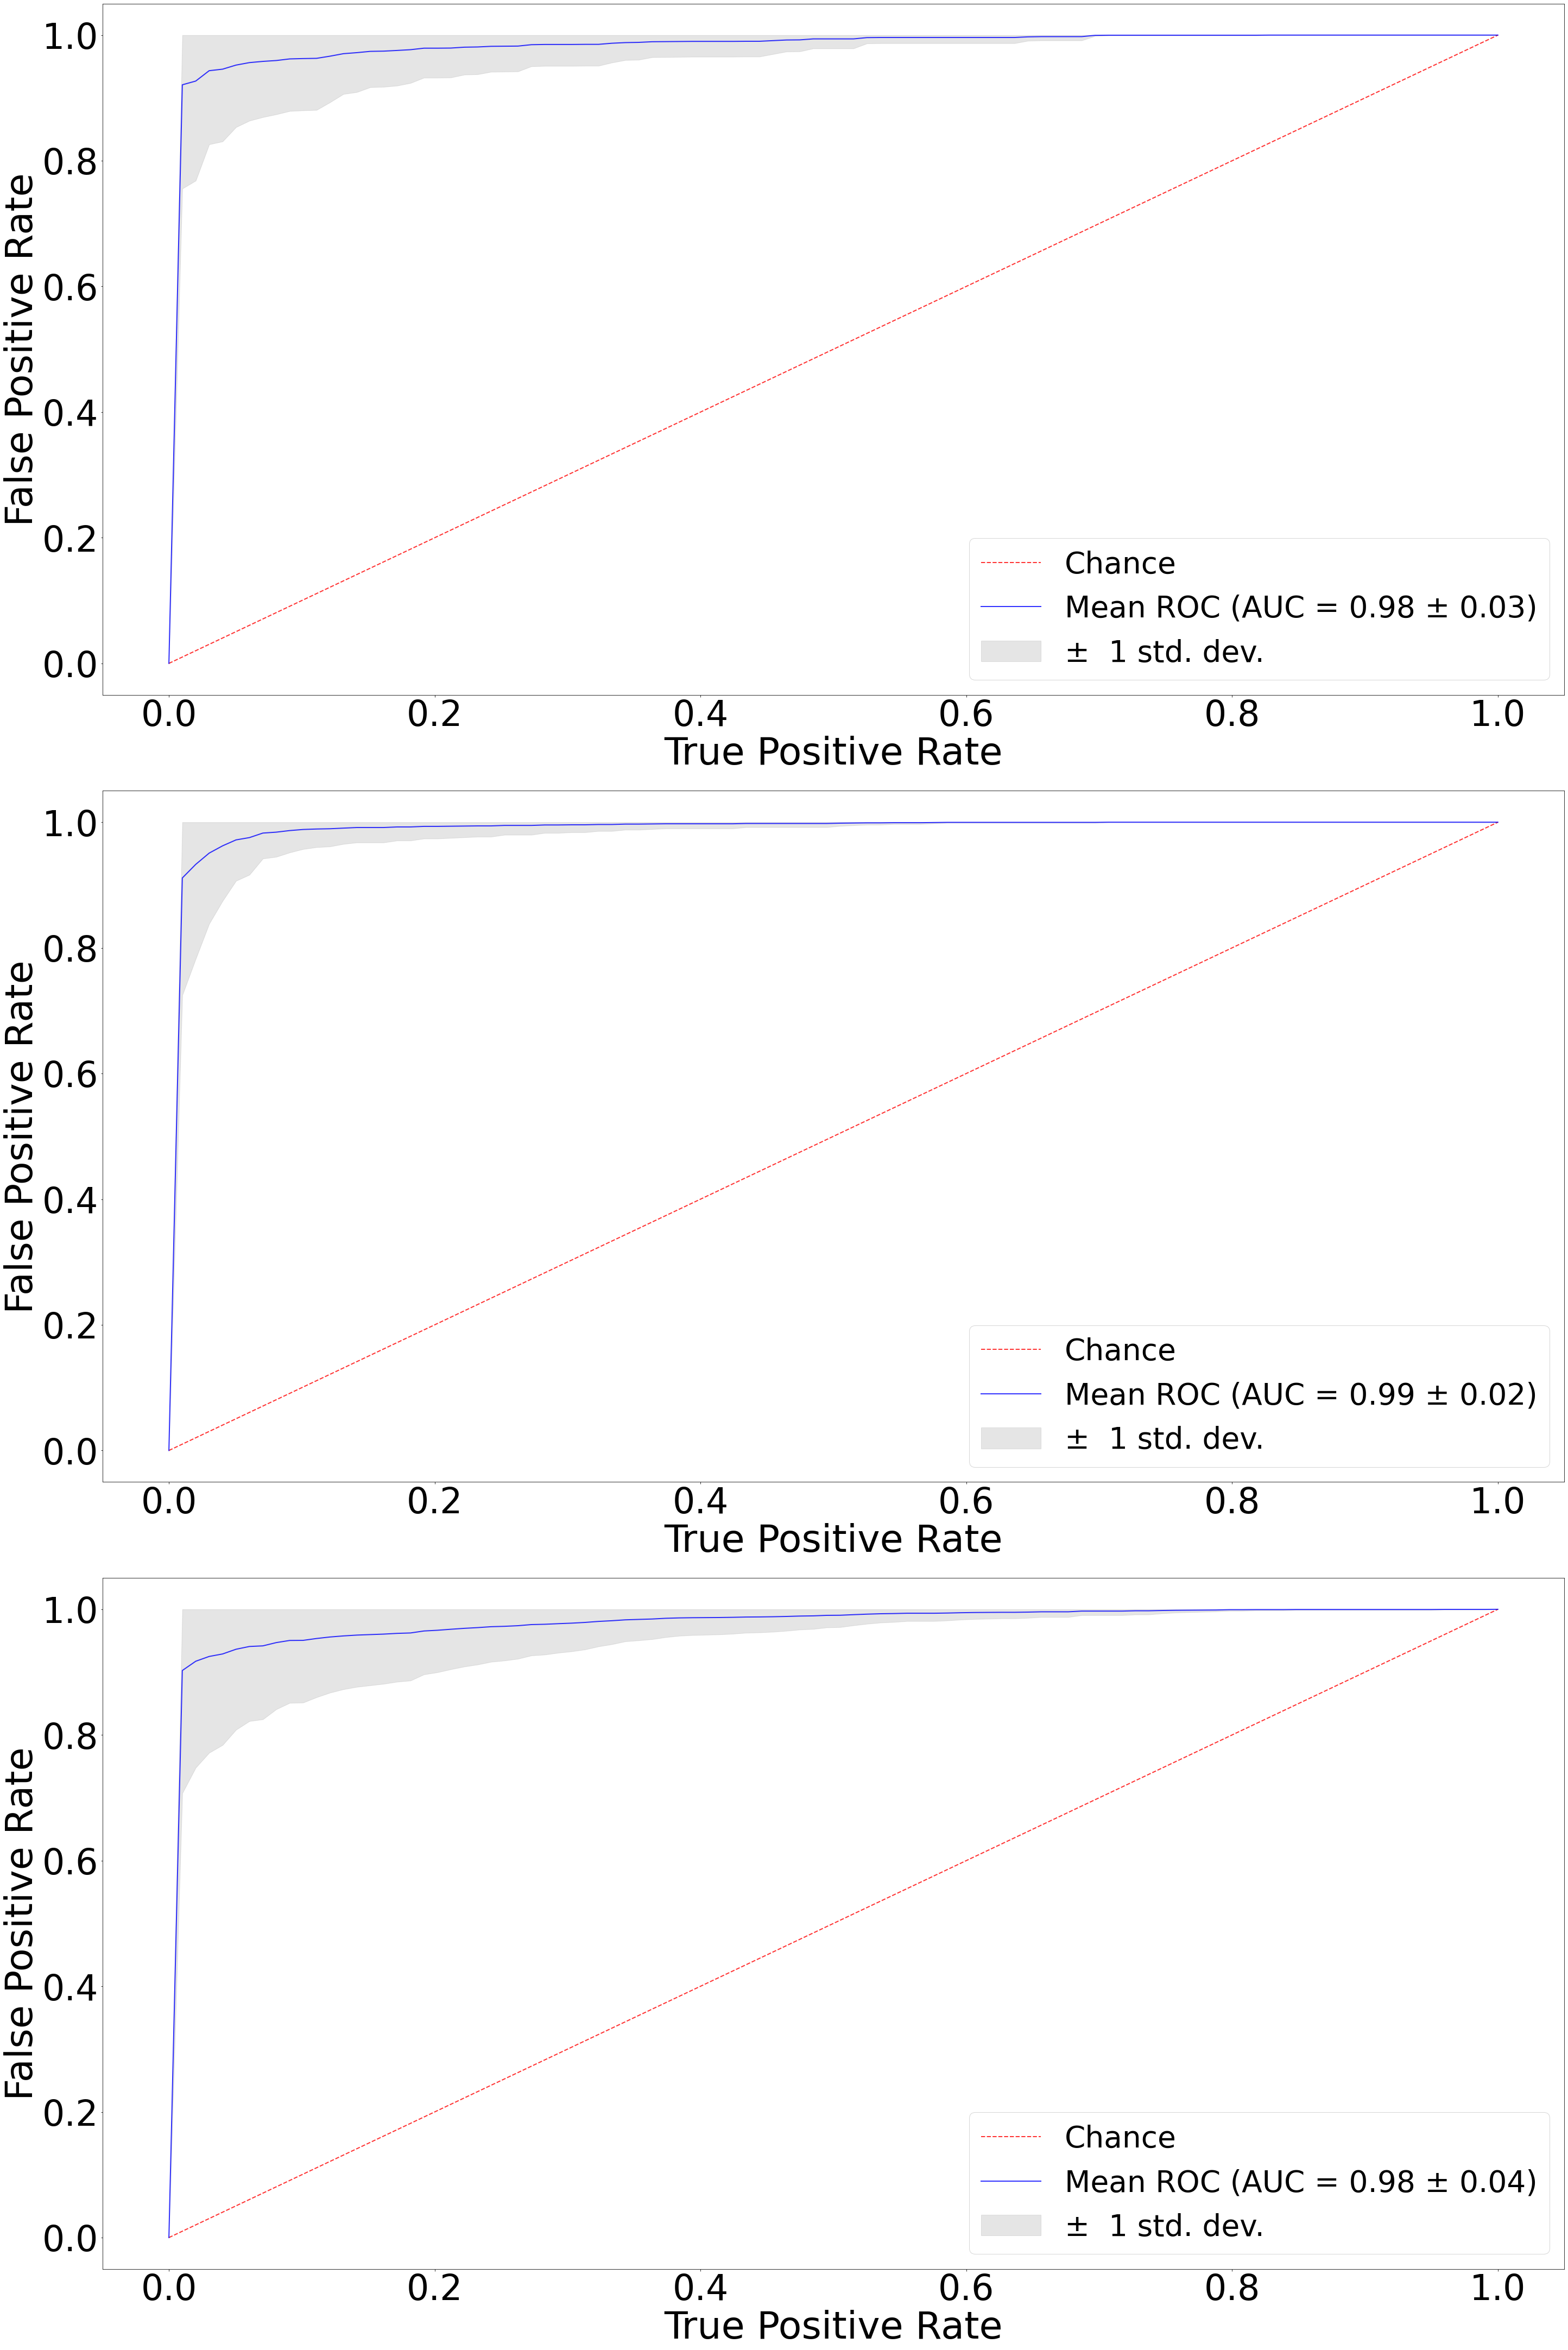

In [243]:
fig = plt.figure(constrained_layout=True, figsize=(40,60))
s_ind = [i for i in range(10)]
subfigs = fig.subfigures(1, 1, wspace=0.07)
axs_right = subfigs.subfigures(3, 1)
for n, (ax, name) in enumerate(zip(axs_right, ['D', 'E', 'F'])):
    ax = ax.subplots(nrows=1, ncols=1)
    plot_roc_curves([metrics_d['log_reg_csp']['tprs'][i][n] for i in s_ind], [metrics_d['log_reg_csp']['aucs'][i][n] for i in s_ind],[metrics_d['log_reg_csp']['pr_v'][i][n] for i in s_ind], [metrics_d['log_reg_csp']['true_v'][i][n] for i in s_ind], plot_all=False, ax=ax)

In [235]:
metrics_d['log_reg_r']

KeyError: 0

In [ ]:
metrics_d['log_reg_r'][i][n]

In [244]:
fig.savefig(f'Results/csp_roc_mean_fin.png', format='png', bbox_inches='tight', dpi=300)

In [228]:
def plot_roc_curves(tprs, aucs, list_predictions, list_y_true, plot_all=True, ax=None):
    """
    function that plot roc curves
    Parameters
    ----------
    tprs: list[float]
    aucs: list[float]
    list_predictions: list[np.ndarray[float]]
        predictions
    list_y_true: list[list[int]]
        true target values
    plot_all: bool
        Plot or not to plot roc for each fold. Default True
    ax:
    Returns
    -------
    :rtype:matplotlib.figure.Figure
    """
    mean_fpr, ret, fig = np.linspace(0, 1, 100), False, None
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ret = True
    if plot_all:
        for i, (y_true, pred) in enumerate(zip(list_y_true, list_predictions)):
            RocCurveDisplay.from_predictions(y_true=y_true, y_pred=pred[:, 1].tolist(), name=f"ROC fold {i + 1}", ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc, std_auc = auc(mean_fpr, mean_tpr), np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper, tprs_lower = np.minimum(mean_tpr + std_tpr, 1), np.maximum(mean_tpr - std_tpr, 0)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} \u00B1 {std_auc:.2f})', lw=2,
            alpha=0.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='\u00B1  1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.tick_params(axis='both', labelsize=65)
    ax.set_xlabel('True Positive Rate', fontsize=70)
    ax.set_ylabel('False Positive Rate', fontsize=70)
    ax.legend(loc='lower right', fontsize=55)
    if ret:
        return fig
    else:
        pass


In [ ]:
index_new_mat

In [ ]:
import pickle

In [ ]:
index_new_not_mat

In [ ]:
import transformers
importlib.reload(transformers)
CSP = transformers.CSP
PCS = transformers.PCS
pjcs = transformers.ProjCommonSpaceCV

In [ ]:
anova_d['log_reg_r'] = results
metrics_d['log_reg_r'] = metrics

In [ ]:
def plot_patterns(coefs_list, eeg_param, subfig=None):
    """
    function that plot filters and patterns on topo
    Parameters
    ----------
    data: list[np.ndarray]
    eeg_param: tuple
        (fr_bands, info)
    subfig
    Returns
    -------
    :rtype:matplotlib.figure.Figure
    """
    min_max, s, vmax, vmin, ret, fig = [], coefs_list[0].shape, 1, -1, False, None
    if subfig is None:
        ret = True
        fig, axes = plt.subplots(nrows=2, ncols=len(eeg_param[0]), figsize=(30, 20))
    else:
        axes = subfig.subplots(nrows=2, ncols=len(eeg_param[0]))
    data = np.mean(coefs_list, axis=0)
    #data = coefs_list[0]
    for name, pos, plot_name, ind in zip(('patterns_', 'filters_'), (0.82, 0.5),
                                         ('Patterns', 'Filters'), (0, 1)):
        for i, key in enumerate(list(eeg_param[0].keys())):
            mne.viz.plot_topomap(data[ind, i, :], eeg_param[1], axes=axes[ind, i],
                                 show=False)
            axes[ind, i].set_title(label=f'{eeg_param[0][key][0]}-{eeg_param[0][key][1]} Hz',
                                   fontdict={'fontsize': 55, 'fontweight': 'semibold'})
            mne.viz.tight_layout()
    if ret:
        if fig is not None:
            return fig
    else:
        return axes

In [ ]:
def plot_roc_curves(tprs, aucs, list_predictions, list_y_true, plot_all=True, ax=None):
    """
    function that plot roc curves
    Parameters
    ----------
    tprs: list[float]
    aucs: list[float]
    list_predictions: list[np.ndarray[float]]
        predictions
    list_y_true: list[list[int]]
        true target values
    plot_all: bool
        Plot or not to plot roc for each fold. Default True
    ax:
    Returns
    -------
    :rtype:matplotlib.figure.Figure
    """
    mean_fpr, ret, fig = np.linspace(0, 1, 100), False, None
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ret = True
    if plot_all:
        for i, (y_true, pred) in enumerate(zip(list_y_true, list_predictions)):
            RocCurveDisplay.from_predictions(y_true=y_true, y_pred=pred[:, 1].tolist(), name=f"ROC fold {i + 1}", ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc, std_auc = auc(mean_fpr, mean_tpr), np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper, tprs_lower = np.minimum(mean_tpr + std_tpr, 1), np.maximum(mean_tpr - std_tpr, 0)
    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} \u00B1 {std_auc:.2f})', lw=2,
            alpha=0.8)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='\u00B1  1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.tick_params(axis='both', labelsize=65)
    ax.set_xlabel('True Positive Rate', fontsize=70)
    ax.set_ylabel('False Positive Rate', fontsize=70)
    ax.legend(loc='lower right', fontsize=55)
    if ret:
        return fig
    else:
        pass

In [ ]:
def merge_fig(fig_type, data, s_ind, metrics, results, settings, inf, roc_plot_all=False, pl=True):
    """
    merge several figures

    Parameters
    ----------
    fig_type
    data: ndarray
    s_ind
    metrics: dict
    results: ndarray
    settings
    inf
    roc_plot_all: bool
    pl: bool

    Returns
    -------
    :rtype:matplotlib.figure.Figure
    """
    if fig_type not in [1, 2]:
        raise ValueError('Please type correct value: 1 for filters/patterns, 2 for feature importance')
    fig = plt.figure(constrained_layout=True, figsize=(75, 60))
    subfigs = fig.subfigures(1, 2, wspace=0.07)
    axs_left, axs_right, bars_l = subfigs[0].subfigures(3, 1), subfigs[1].subfigures(3, 1), []
    for side, pos in zip(['left', 'right'], [1, 2]):
        bars_l.append(tqdm(range(3), total=3, desc=f'Draw 3 {side} plots', leave=False, position=pos))
    for n, (ax, name) in enumerate(zip(axs_left, ['A', 'B', 'C'])):
        bars_l[0].update(1)
        ax.text(-0.05, 0.5, f'{name}', fontdict={'fontsize': 90, 'fontweight': 'semibold'})
        if fig_type == 1:
            ax_bar = plot_patterns(list(compress(data[s_ind, n, ...], results[s_ind, n, 1] > 0.5)),
                                   [settings.fr_bands, inf], ax)
        if fig_type == 2:
            ax_bar = plot_feature_importance(list(compress(data[s_ind, n, ...], results[s_ind, n, 1] > 0.5)),
                                             [settings.fr_bands, inf], ax)
            if n == 2:
                m = cm.ScalarMappable(cmap='hot')
                m.set_array(np.array([0, 1]))
                cb = subfigs[0].colorbar(m, ax=ax_bar, shrink=0.6, pad=0.3, location='bottom')
                cb.ax.tick_params(labelsize=80)
    for n, (ax, name) in enumerate(zip(axs_right, ['D', 'E', 'F'])):
        bars_l[1].update(1)
        ax.text(-0.05, 0.5, f'{name}', fontdict={'fontsize': 90, 'fontweight': 'semibold'})
        ax = ax.subplots(nrows=1, ncols=1)
        plot_roc_curves([metrics['tprs'][i][n] for i in s_ind], [metrics['aucs'][i][n] for i in s_ind],
                        [metrics['pr_v'][i][n] for i in s_ind], [metrics['true_v'][i][n] for i in s_ind],
                        plot_all=roc_plot_all, ax=ax)
    if pl:
        plt.show()
    else:
        plt.close(fig)
    return fig

In [ ]:
fig = merge_fig(1, coefs, range(10), metrics, results, settings, data['info_object'], roc_plot_all=True)

In [ ]:
fig.savefig('Results/log_reg_cross_subject_fp.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
import transformers
importlib.reload(transformers)
CSP = transformers.CSP
CSPCv = transformers.CSPCv
PCS = transformers.ProjCommonSpaceCV

In [ ]:
results = np.zeros((len(index_new_mat), len(settings.dict_cls), 2))
coefs = np.zeros((len(index_new_mat), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_new_mat, index_new_not_mat)), total=len(index_new_mat),
                                      desc=f'Evaluation for {len(index_new_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for ind in range(3):
        # subjects for cv
        s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_new_mat if i != s_ind_1]), random.choice(
            [i for i in index_new_not_mat if i != s_ind_2])
        y_train = [1] * sum([col_ll2[i][ind][0].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [
            0] * sum([col_ll2[i][ind][0].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
        x_train = [col_ll2[i][ind] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]]
        y_val = [1] * col_ll2[s_ind_1_cv][ind][0].shape[0] + [0] * col_ll2[s_ind_2_cv][ind][0].shape[0]
        x_val = [col_ll2[i][ind] for i in [s_ind_1_cv, s_ind_2_cv]]
        y_test = [1] * col_ll2[s_ind_1][ind][0].shape[0] + [0] * col_ll2[s_ind_2][ind][0].shape[0]
        x_test = [col_ll2[i][ind] for i in [s_ind_1, s_ind_2]]
        csp_tr, csp_val, csp_t = np.zeros((len(y_train), 7, 465)), np.zeros((len(y_val), 7, 465)), np.zeros(
            (len(y_test), 7, 465))
        for n in range(7):
            ts = pyriemann.tangentspace.TangentSpace()
            pc = coffeine.ProjCommonSpace(n_compo=30)
            pc.fit(np.concatenate([x_train[i][n] for i in range(len(x_train))]))
            x_train1 = pc.transform(np.concatenate([x_train[i][n] for i in range(len(x_train))]))
            csp_tr[:, n, :] = ts.fit_transform(np.stack([x_train1['cov'][i] for i in range(len(x_train1['cov']))]))
            x_val1 = pc.transform(np.concatenate([x_val[i][n] for i in range(len(x_val))]))
            csp_val[:, n, :] = ts.transform(np.stack([x_val1['cov'][i] for i in range(len(x_val1['cov']))]))
            x_test1 = pc.transform(np.concatenate([x_test[i][n] for i in range(len(x_test))]))
            csp_t[:, n, :] = ts.transform(np.stack([x_test1['cov'][i] for i in range(len(x_test1['cov']))]))
        x_train, x_val, x_test = csp_tr.reshape(len(csp_tr), -1), csp_val.reshape(len(csp_val), -1), csp_t.reshape(
            len(csp_t), -1)
        x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
        ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
        x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val

        ac, roc_auc, interp_tpr, y_predict_pr = predict_lm([x_train, x_test, y_train, y_test],
                                                           [settings.fr_bands, data['chan_names']], ps=ps)
        results[count, ind, ...] = ac, roc_auc
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['log_reg_ir'] = results
metrics_d['log_reg_ir'] = metrics

<center><b>Classification of tasks in both groups</b></center>

In [ ]:
# dict for ANOVA between methods and accuracy bars
metrics_d = {}
anova_d = {}

<center>Logistic regression</center>

In [ ]:
results = np.zeros((len(all_codes), len(settings.dict_cls), 2))
coefs = np.zeros((len(all_codes), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for num, subj in tqdm(enumerate(range(len(all_codes))), total=len(all_codes),
                      desc=f'Evaluation for {len(all_codes)}  subjects', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for i, key in enumerate(list(settings.dict_cls.keys())):
        ind = settings.dict_cls[key]
        a, b = data['spectra_feat'][subj][ind[0]], data['spectra_feat'][subj][ind[1]]
        x = np.concatenate((a, b), axis=0)
        y = np.array([0] * a.shape[0] + [1] * b.shape[0])
        x_train, x_test, y_train, y_test = train_test_split(x.reshape(x.shape[0], -1), y, test_size=0.3)
        ac, roc_auc, interp_tpr, coef_ev, y_predict_pr = predict_lm([x_train, x_test, y_train, y_test],
                                                                    [settings.fr_bands, data['chan_names']])
        results[subj, i, ...] = ac, roc_auc
        coefs[subj, i, ...] = coef_ev
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['log_reg'] = results
metrics_d['log_reg'] = metrics

In [ ]:
# evaluate mean and var for all subjects/and for subjects in groups
list_gr, ar_mean_var = [results, results[index_mat, ...], results[index_not_mat, ...]], np.zeros(
    (len(settings.dict_cls), 12))
list_names_subj, list_names_fin = [], []
metr_name = ['accuracy', 'ROC/AUC']
for i, key in enumerate(list(settings.dict_cls.keys())):
    ar_mean_var[i, ...] = np.array(
        list(chain.from_iterable((a, b) for a, b in zip(list_gr[i].reshape((list_gr[i].shape[0], -1)).
                                                        mean(axis=0),
                                                        list_gr[i].reshape((list_gr[i].shape[0], -1)).var(axis=0)))))
    list_names_subj.extend([f'{key} {name}' for name in metr_name])
    list_names_fin.extend([f'{key} {name}' for name in [f'{i} {j}' for i in metr_name
                                                        for j in ['mean', 'var']]])

# save results to table
df_subj = pd.DataFrame(results.reshape((len(all_codes
                                            ), -1)), columns=list_names_subj, index=all_codes
                       )
df_fin = pd.DataFrame(ar_mean_var, columns=list_names_fin,
                      index=['all_subjects', 'mathematicians', 'not_mathematicians'])
writer = pd.ExcelWriter('Results/ind_tasks_log_reg', engine='xlsxwriter')
df_subj.to_excel(writer, sheet_name='all_subj')
df_fin.to_excel(writer, sheet_name='mean_var')
writer.save()

In [ ]:
# create results figures
list_of_fig = []
for i in tqdm([index_all, index_mat, index_not_mat], total=3, desc=f'Plot for {3}  groups', position=0):
    list_of_fig.append(merge_fig(1, coefs, i, metrics, results, settings, data['info_object']))

In [ ]:
# save plots
for fig, name in zip(list_of_fig, ['all', 'math', 'not_math']):
    fig.savefig(f'Results/log_reg_ind_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

<center>LightGBM</center>

In [ ]:
results = np.zeros((len(all_codes), len(settings.dict_cls), 2))
feat_import = np.zeros((len(all_codes), len(settings.dict_cls), len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for num, subj in tqdm(enumerate(range(len(all_codes))), total=len(all_codes),
                      desc=f'Evaluation for {len(all_codes)}  subjects', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for i, key in enumerate(list(settings.dict_cls.keys())):
        ind = settings.dict_cls[key]
        a, b = data['spectra_feat'][subj][ind[0]], data['spectra_feat'][subj][ind[1]]
        x = np.concatenate((a, b), axis=0)
        y = np.array([0] * a.shape[0] + [1] * b.shape[0])
        x_train, x_test, y_train, y_test = train_test_split(x.reshape(x.shape[0], -1), y, test_size=0.3)
        ac, roc_auc, interp_tpr, feature_imp_ev, y_predict_pr = predict_lgbm([x_train, x_test, y_train, y_test],
                                                                             [settings.fr_bands, data['chan_names']])
        results[subj, i, ...] = ac, roc_auc
        feat_import[subj, i, ...] = feature_imp_ev
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['lgb'] = results
metrics_d['lgb'] = metrics

In [ ]:
# evaluate mean and var for all subjects/and for subjects in groups
list_gr, ar_mean_var = [results, results[index_mat, ...], results[index_not_mat, ...]], np.zeros(
    (len(settings.dict_cls), 12))
list_names_subj, list_names_fin = [], []
metr_name = ['accuracy', 'ROC/AUC']
for i, key in enumerate(list(settings.dict_cls.keys())):
    ar_mean_var[i, ...] = np.array(
        list(chain.from_iterable((a, b) for a, b in zip(list_gr[i].reshape((list_gr[i].shape[0], -1)).
                                                        mean(axis=0),
                                                        list_gr[i].reshape((list_gr[i].shape[0], -1)).var(axis=0)))))
    list_names_subj.extend([f'{key} {name}' for name in metr_name])
    list_names_fin.extend([f'{key} {name}' for name in [f'{i} {j}' for i in metr_name
                                                        for j in ['mean', 'var']]])

# save results to table
df_subj = pd.DataFrame(results.reshape((len(all_codes
                                            ), -1)), columns=list_names_subj, index=all_codes
                       )
df_fin = pd.DataFrame(ar_mean_var, columns=list_names_fin,
                      index=['all_subjects', 'mathematicians', 'not_mathematicians'])
writer = pd.ExcelWriter('Results/ind_tasks_lightgbm', engine='xlsxwriter')
df_subj.to_excel(writer, sheet_name='all_subj')
df_fin.to_excel(writer, sheet_name='mean_var')
writer.save()

In [ ]:
# create results figures
list_of_fig = []
for i in tqdm([index_all, index_mat, index_not_mat], total=3, desc=f'Plot for {3}  groups', position=0):
    list_of_fig.append(merge_fig(2, feat_import, i, metrics, results, settings, data['info_object']))

In [ ]:
# save plots
for fig, name in zip(list_of_fig, ['all', 'math', 'not_math']):
    fig.savefig(f'Results/lgb_ind_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

<center><b>Cross-subject classification of subject group</b></center>

<center>Logistic regression</center>

In [ ]:
results = np.zeros((len(index_new_mat), len(settings.dict_cls), 2))
coefs = np.zeros((len(index_new_mat), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}

for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_new_mat, index_new_not_mat)), total=len(index_new_mat),
                                      desc=f'Evaluation for {len(index_new_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    for ind in range(len(settings.dict_cls)):
        # subjects for cv
        s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_new_mat if i != s_ind_1]), random.choice(
            [i for i in index_new_not_mat if i != s_ind_2])
        y_train = [1] * sum(
            [data['spectra_feat'][i][ind].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [0] * sum(
            [data['spectra_feat'][i][ind].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
        x_train = np.concatenate(
            [data['spectra_feat'][i][ind] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]],
            axis=0).reshape(len(y_train), -1)
        y_val = [1] * data['spectra_feat'][s_ind_1_cv][ind].shape[0] + [0] *
                data['spectra_feat'][s_ind_2_cv][ind].shape[0]
        x_val = np.concatenate([data['spectra_feat'][i][ind] for i in [s_ind_1_cv, s_ind_2_cv]], axis=0).reshape(
            len(y_val), -1)
        y_test = [1] * data['spectra_feat'][s_ind_1][ind].shape[0] + [0] * data['spectra_feat'][s_ind_2][ind].shape[0]
        x_test = np.concatenate([data['spectra_feat'][i][ind] for i in [s_ind_1, s_ind_2]], axis=0).reshape(len(y_test),
                                                                                                            -1)
        x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
        ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
        x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
        ac, roc_auc, interp_tpr, coef_ev, y_predict_pr = predict_lm([x_train, x_test, y_train, y_test],
                                                                    [settings.fr_bands, data['chan_names']], ps=ps)
        results[count, ind, ...] = ac, roc_auc
        coefs[count, ind, ...] = coef_ev
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['log_reg_gr'] = results
metrics_d['log_reg_gr'] = metrics

In [ ]:
# create result figure
fig = merge_fig(1, coefs, range(10), metrics, results, settings, data['info_object'], roc_plot_all=True)

In [ ]:
# save figure
fig.savefig('Results/log_reg_cross_subject_group.png', format='png', bbox_inches='tight', dpi=300)

<center>LightGBM</center>

In [9]:
import pickle
import mne
import numpy as np
from itertools import compress

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm
from lightgbm import LGBMClassifier as lgbm

In [10]:
import shap
def predict_lgbm(data, eeg_param, ps=None):
    """
    function for LightGBM model
    Parameters
    ----------
    data: list[np.ndarray]
    eeg_param: list[dict, list]
        [fr_bands, channels_names]
    Returns
    -------
    :rtype: tuple
    :return: ac, roc_auc, interp_tpr, feature_importances, y_predict_pr
    """
    mean_fpr = np.linspace(0, 1, 100)
    sc = StandardScaler()
    data[0] = sc.fit_transform(data[0])
    data[1] = sc.transform(data[1])
    fit_params = {'objective': 'binary', 'num_leaves': 30}
    m = lgbm(**fit_params)
    param_grid = {'reg_lambda': [0.5]}
    if ps is None:
        ps = 5
    model = GridSearchCV(m, param_grid, cv=ps)
    model.fit(data[0], data[2])
    feature_importances = ((model.best_estimator_.feature_importances_ / sum(model.best_estimator_
                                                                             .feature_importances_)) * 100).reshape(
        (len(eeg_param[0]), len(eeg_param[1])))
    y_predict, y_predict_pr = model.predict(data[1]), model.predict_proba(data[1])
    shap_values = shap.TreeExplainer(model.best_estimator_).shap_values(data[1])
    ac = balanced_accuracy_score(data[3], y_predict)
    fpr, tpr, _ = roc_curve(data[3], y_predict_pr[:, 0], pos_label=0)
    roc_auc, interp_tpr = auc(fpr, tpr), np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return ac, roc_auc, interp_tpr, feature_importances, y_predict_pr, shap_values, data[1]

In [11]:
results = np.zeros((len(index_new_mat), len(settings.dict_cls), 2))
feat_import = np.zeros((len(index_new_mat), len(settings.dict_cls), len(settings.fr_bands), len(data['chan_names'])))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}
sh_v = []
x_tf = []
for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_new_mat, index_new_not_mat)), total=len(index_new_mat),
                                      desc=f'Evaluation for {len(index_new_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    sh_v1 = []
    x_t1 = []
    for ind in range(len(settings.dict_cls)):
        # subjects for cv
        s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_new_mat if i != s_ind_1]), random.choice(
            [i for i in index_new_not_mat if i != s_ind_2])
        y_train = [1] * sum(
            [data['spectra_feat'][i][ind].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [0] * sum(
            [data['spectra_feat'][i][ind].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
        x_train = np.concatenate(
            [data['spectra_feat'][i][ind] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]],
            axis=0).reshape(len(y_train), -1)
        y_val = [1] * data['spectra_feat'][s_ind_1_cv][ind].shape[0] + [0] * data['spectra_feat'][s_ind_2_cv][ind].shape[0]
        x_val = np.concatenate([data['spectra_feat'][i][ind] for i in [s_ind_1_cv, s_ind_2_cv]], axis=0).reshape(
            len(y_val), -1)
        y_test = [1] * data['spectra_feat'][s_ind_1][ind].shape[0] + [0] * data['spectra_feat'][s_ind_2][ind].shape[0]
        x_test = np.concatenate([data['spectra_feat'][i][ind] for i in [s_ind_1, s_ind_2]], axis=0).reshape(len(y_test),
                                                                                                            -1)
        x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
        ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
        x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
        ac, roc_auc, interp_tpr, coef_ev, y_predict_pr, s_v, x_t = predict_lgbm([x_train, x_test, y_train, y_test],
                                                                      [settings.fr_bands, data['chan_names']], ps=ps)
        sh_v1.append(s_v)
        x_t1.append(x_t)
        results[count, ind, ...] = ac, roc_auc
        feat_import[count, ind, ...] = coef_ev
        for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
            metrics_loop[k].append(v)
    sh_v.append(sh_v1)
    x_tf.append(x_t1)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['lgbm_gr'] = results
metrics_d['lgbm_gr'] = metrics

Evaluation for 10 folds:   0%|          | 0/10 [00:00<?, ?it/s]LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Evaluation for 10 folds:  10%|█         | 1/10 [00:19<02:53, 19.33s/it]LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
Evaluation for 10 folds:  20%|██        | 2/10 [00:36<02:25, 18.22s/it]LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM bi

NameError: name 'anova_d' is not defined

In [ ]:
metrics_d['log_reg_gr_t']

In [ ]:
results[:,0,0]

In [ ]:
len(sh_v[0])

In [ ]:
data['info']

In [ ]:
sh_v[0][0].summary_plot(shap_values, valid_x)

In [ ]:
x_tf[0][0].shape

In [ ]:
sh_v[0][0][1].shape

In [ ]:
len(sh_v)

In [ ]:
data['spectra_feat'][0][0].shape

In [ ]:
data['chan_names']

In [ ]:
list(settings.fr_bands.keys())

In [ ]:
results[:,0,0]

In [ ]:
import matplotlib.pyplot as plt
fig=plt.gcf()
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in data['chan_names']], show=False, max_display = 10)
fig.savefig('Results/lgb_cross_subject_group_importance.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
mne.viz.plot_topomap(np.abs(shap_values[:,-95:]).mean(0).round(2),  data['info_object'], show=False, cmap='hot',)
mne.viz.tight_layout()

In [ ]:
from eeg_lib import c_bar

NameError: name 'c_bar' is not defined

<Figure size 432x288 with 0 Axes>

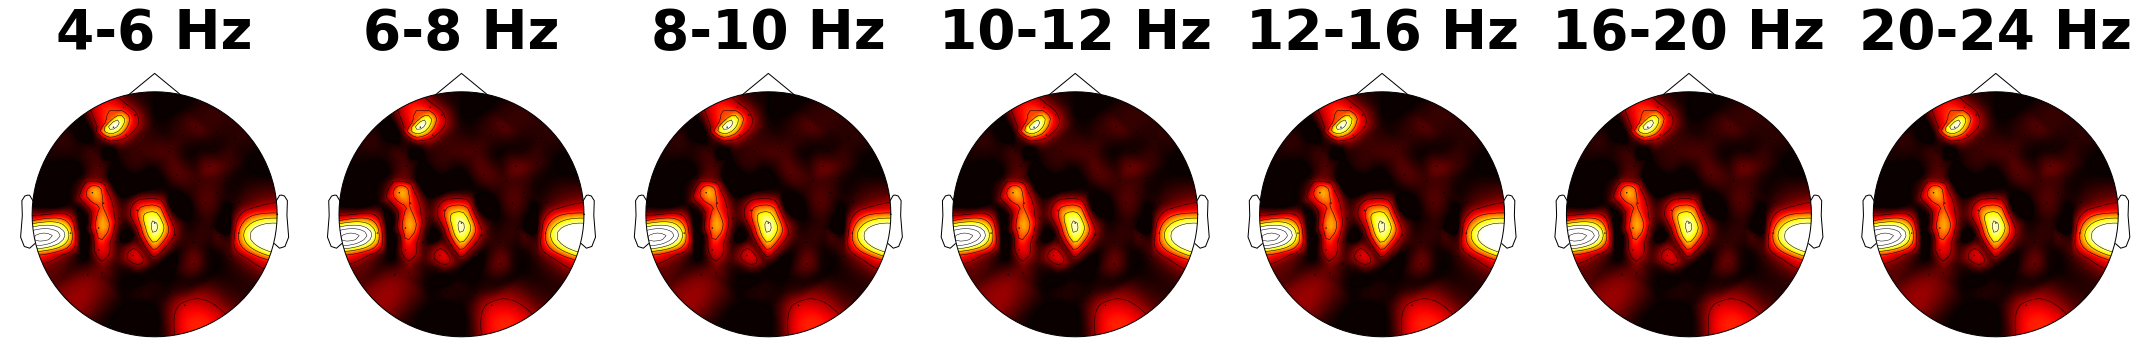

In [22]:
ret = True
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=len(settings.fr_bands), figsize=(30, 20))
vmin = np.abs(shap_values).mean(0).round(2).min()
vmax = np.abs(shap_values).mean(0).round(2).max()
for i, key in enumerate(list(settings.fr_bands.keys())):
        mne.viz.plot_topomap(np.abs(shap_values[:,-92:]).mean(0).round(2), data['info_object'], axes=axes[i], cmap='hot', show=False)
        axes[i].set_title(label=f'{settings.fr_bands[key][0]}-{settings.fr_bands[key][1]} Hz',
                          fontdict={'fontsize': 55, 'fontweight': 'semibold'})
        mne.viz.tight_layout()
if ret:
    if fig is not None:
        c_bar(vmin, vmax, 'hot', fig)
plt.tight_layout()
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in data['chan_names']], show=False, max_display = 10, plot_size=None)

In [ ]:
shap_values.shape

In [ ]:
mask = np.zeros(len(data['chan_names']))
        for ch in ['E103', 'E35']:
            mask[data['chan_names'].index(ch)] = 1
        mask.astype(bool)

In [ ]:
plt.tight_layout()

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


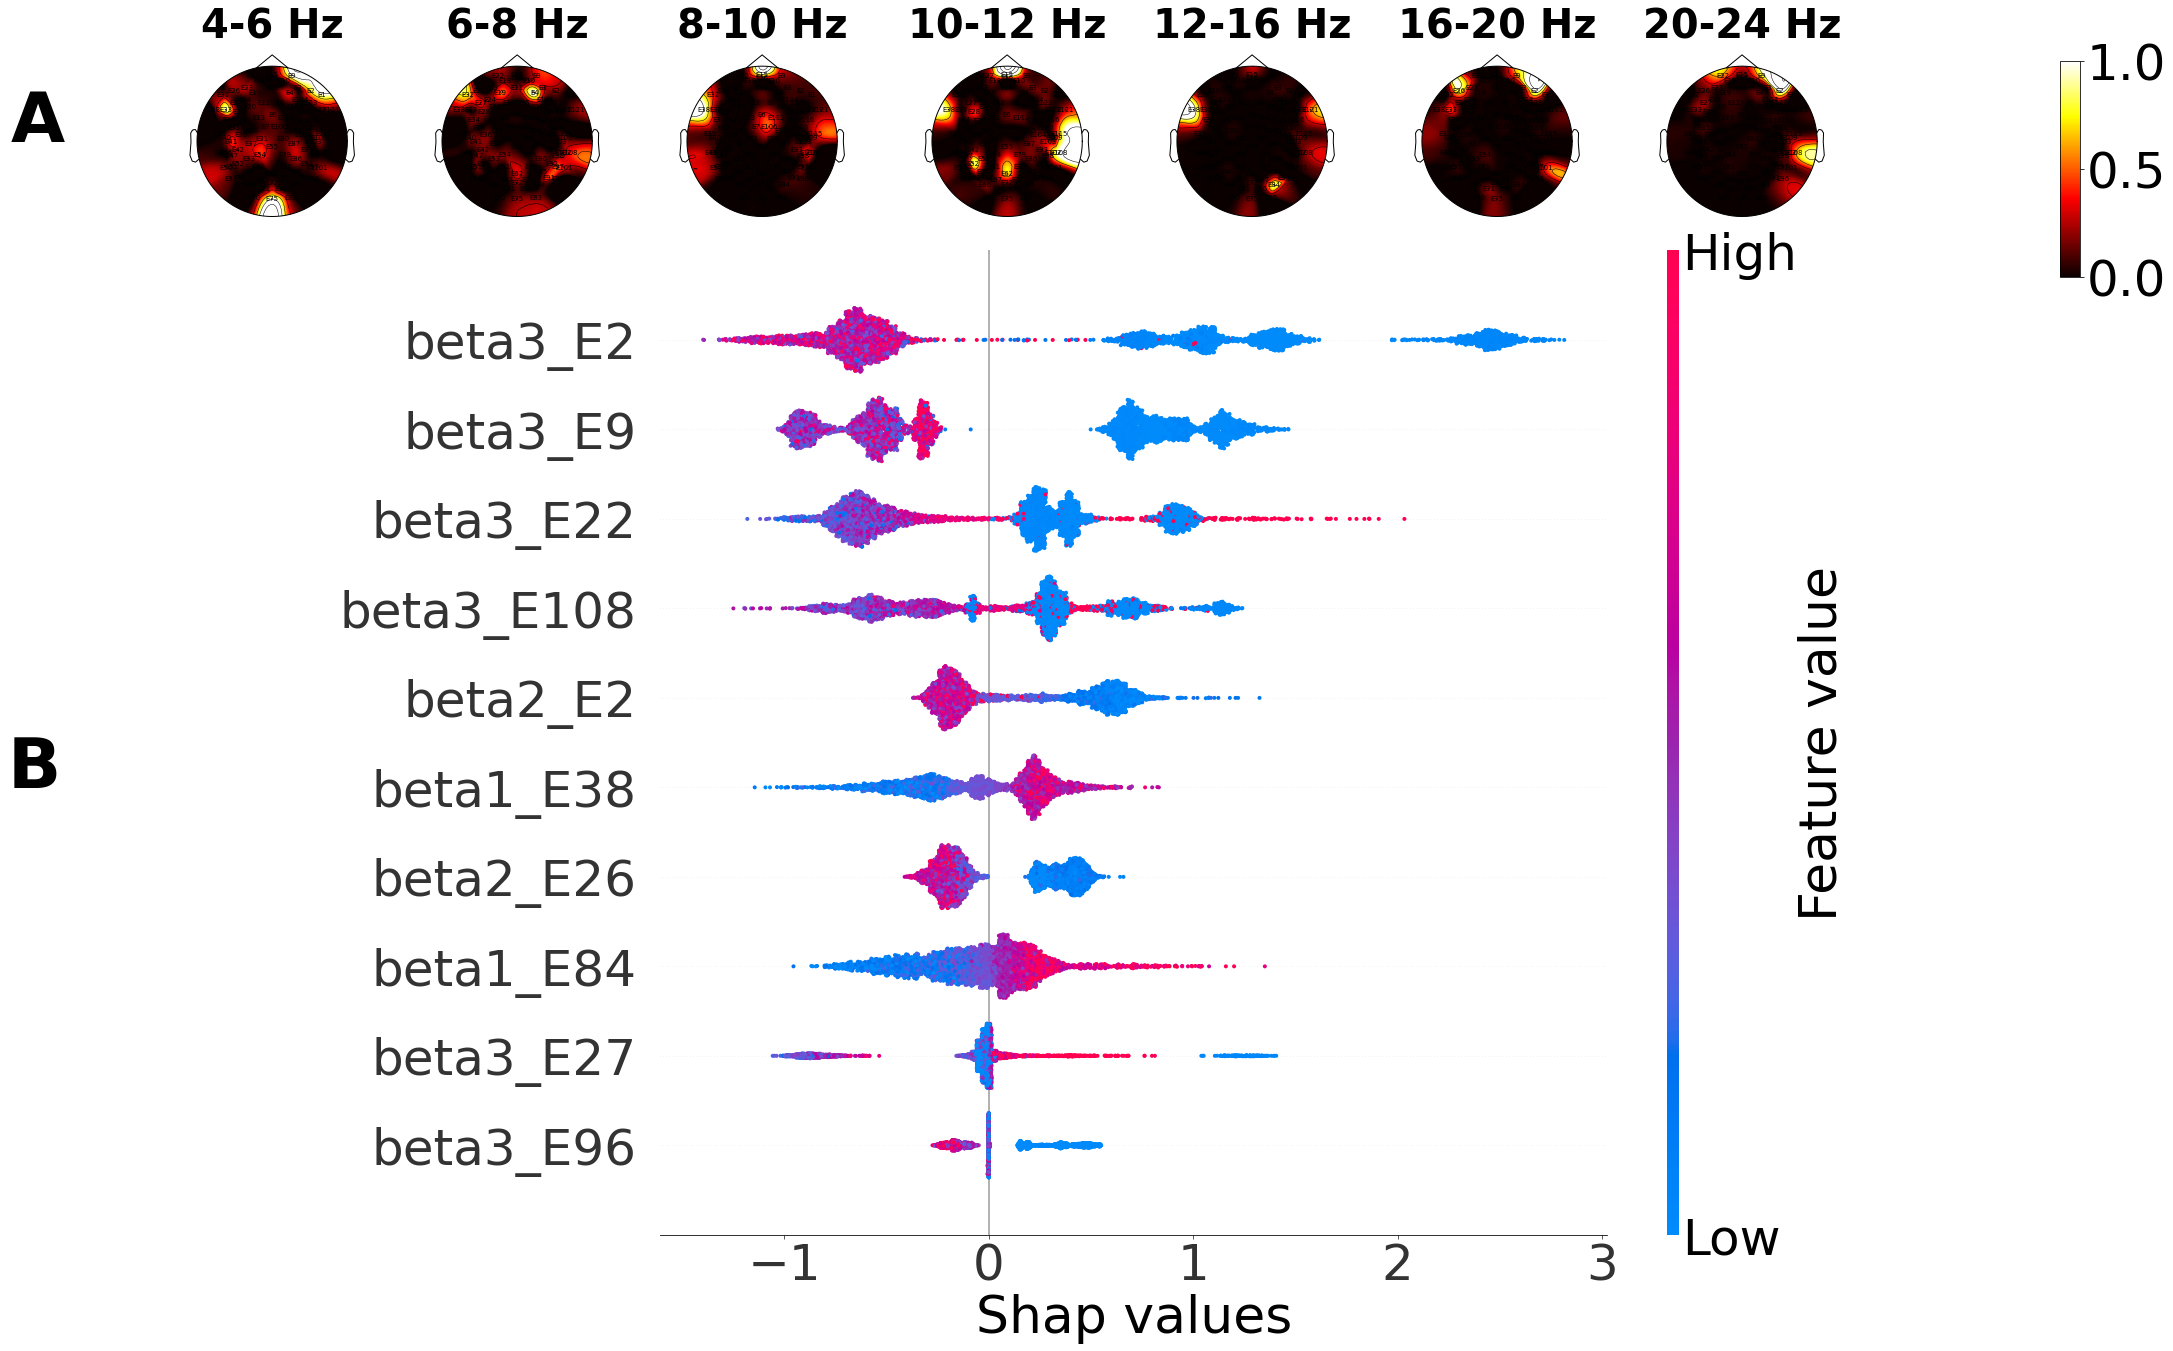

In [119]:
fig = plt.figure(figsize=(30, 20))
plt.tight_layout()
grid = plt.GridSpec(6, 7)
for i, key in enumerate(list(settings.fr_bands.keys())):
        plt.subplot(grid[0, i])
        if i == 0:
            plt.text(-0.33, 0, f'A', fontdict={'fontsize': 70, 'fontweight': 'semibold'})
        mne.viz.plot_topomap(np.abs(shap_values[:, (92*(i)):((i+1)*92)]).mean(0).round(2), data['info_object'], cmap='hot', show=False, names=data['chan_names'], show_names=True)
        plt.subplot(grid[0, i]).set_title(label=f'{settings.fr_bands[key][0]}-{settings.fr_bands[key][1]} Hz',
                          fontdict={'fontsize': 40, 'fontweight': 'semibold'})
m = cm.ScalarMappable(cmap='hot')
coord = [1, 0.79, 0.009, 0.15]
cax = fig.add_axes(coord)
m.set_array(np.array([0, 1]))
plt.colorbar(m, cax, fraction=0.051, pad=0.012 )
plt.tick_params(axis='both', which='major', labelsize=50)
plt.subplot(grid[1:, 2:])
plt.text(-4.8, 4, f'B', fontdict={'fontsize': 70, 'fontweight': 'semibold'})
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in data['chan_names']], show=False, max_display = 10, plot_size = (30,20))
plt.tight_layout()
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(axis='both', which='major', labelsize=50)
fig.axes[-1].tick_params(axis='both', which='major', labelsize=50)
fig.axes[-1].set_ylabel('Feature value', fontsize=52)
ax.set_xlabel('Shap values', fontsize=52)
plt.tight_layout()
plt.show()

In [19]:
shap_values.shape

(3094, 644)

In [120]:
fig.savefig('Results/shap_importance_lgbm_244.png', format='png', bbox_inches='tight', dpi=300)

In [15]:
len(x_tf[0])

3

In [116]:
test_set = np.concatenate([x_tf[i][2] for i in range(5)])
shap_values = np.concatenate([sh_v[i][2][1] for i in range(5)])

In [ ]:
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in data['chan_names']], show=False, max_display = 30, plot_size=(30,20))
fig, ax = plt.gcf(), plt.gca()

In [ ]:
fig.savefig('Results/log_importance_lgbm.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
sh_v[0][0][1].shape

In [ ]:
data['chan_names']

In [ ]:
fig.savefig('Results/lgb_cross_subject_group_shap_topo.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
data['chan_names'].index('E103')

In [ ]:
data['chan_names']

In [ ]:
fig.savefig('Results/lgb_cross_subject_group_shap_topo.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
np.array([0, 1])

In [ ]:
grid = plt.GridSpec(2, 6, wspace=0.4, hspace=0.3)

In [ ]:
fig = merge_fig(2, data, range(10), metrics, results, settings, data['info_object'], roc_plot_all=True)

In [ ]:
fig.savefig('Results/lgb_cross_subject_group_shap.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
shap.__version__

In [ ]:
np.abs(shap_values[:,-95:]).mean(0).round(2)

In [ ]:
shap_values.shape

In [ ]:
np.array(data['chan_names'])

In [ ]:
shap_values.values

In [ ]:
shap_values[:, -95:].mean(axis=0)

In [ ]:
shap_values[:, 0:95].mean(axis=0).shape

In [ ]:
data['info_object']

In [ ]:
shap_values.shape

In [ ]:
len(x_tf)

In [ ]:
test_set = np.concatenate([x_tf[i][0] for i in range(5)])
shap_values = np.concatenate([sh_v[i][0][1] for i in range(5)])

In [ ]:
shap_values.shape

In [ ]:
for i in range(1,len(list_test_sets)):

    shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)

In [ ]:
f.savefig('Results/lgb_cross_subject_group_importance.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.pyplot as pl
f = pl.gcf()

In [ ]:
# create result figure
fig = merge_fig(2, feat_import, range(10), metrics, results, settings, data['info_object'], roc_plot_all=True)

In [ ]:
# save figure
fig.savefig('Results/lgb_cross_subject_group.png', format='png', bbox_inches='tight', dpi=300)

<center><b>Cross-subject classification of tasks</b></center>

<center>Logistic regression</center>

In [ ]:
results = np.zeros((2, len(index_new_mat), len(settings.dict_cls), 2))
coefs = np.zeros((2, len(index_new_mat), len(settings.dict_cls), 2, len(settings.fr_bands), len(data['chan_names'])))
m_list = []

for group_ind, subj_type in tqdm(enumerate([index_new_mat, index_new_not_mat]), total=2,
                                 desc=f'Evaluation for 2 groups', position=0):
    metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}
    for count, s_ind in tqdm(enumerate(subj_type), total=len(index_new_mat),
                             desc=f'Evaluation for {len(index_new_mat)} folds', position=1):
        metrics_loop = {k: [] for k in range(4)}
        for i, key in enumerate(list(settings.dict_cls.keys())):
            # subjects for cv
            s_ind_cv = random.sample([i for i in subj_type if i != s_ind], 2)
            ind = settings.dict_cls[key]
            y_train = sum(
                [[0] * data['spectra_feat'][i][ind[0]].shape[0] + [1] * data['spectra_feat'][i][ind[1]].shape[0] for i
                 in subj_type if i not in s_ind_cv + [s_ind]], [])
            x_train = np.concatenate([data['spectra_feat'][i][ind[j]] for i in subj_type for j in [0, 1]
                                      if i not in s_ind_cv + [s_ind]], axis=0).reshape(len(y_train), -1)
            y_val = sum(
                [[0] * data['spectra_feat'][i][ind[0]].shape[0] + [1] * data['spectra_feat'][i][ind[1]].shape[0] for i
                 in s_ind_cv], [])
            x_val = np.concatenate([data['spectra_feat'][i][ind[j]] for i in s_ind_cv for j in [0, 1]], axis=0)
                .reshape(len(y_val), -1)
            y_test = [0] * data['spectra_feat'][s_ind][ind[0]].shape[0] + [1] *
                     data['spectra_feat'][s_ind][ind[1]].shape[0]
            x_test = np.concatenate([data['spectra_feat'][s_ind][ind[0]], data['spectra_feat'][s_ind][ind[1]]])
                .reshape(len(y_test), -1)
            x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
            ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
            x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
            ac, roc_auc, interp_tpr, coef_ev, y_predict_pr = predict_lm([x_train, x_test, y_train, y_test],
                                                                        [settings.fr_bands, data['chan_names']],
                                                                        ps=ps)
            results[group_ind, count, i, ...] = ac, roc_auc
            coefs[group_ind, count, i, ...] = coef_ev
            for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
                metrics_loop[k].append(v)
        for k, v in zip(metrics.keys(), metrics_loop.values()):
            metrics[k].append(v)
    m_list.append(metrics)

anova_d['log_reg_gr_t'] = results
metrics_d['log_reg_gr_t'] = m_list

In [ ]:
# create results figures
list_of_fig = []
for i in tqdm([0, 1], total=2, desc=f'Plot for {2}  groups', position=0):
    list_of_fig.append(merge_fig(1, coefs[i, ...], range(10), m_list[i], results[i, ...], settings, data['info_object'],
                                 roc_plot_all=True))

In [ ]:
# save plots
for fig, name in zip(list_of_fig, ['math', 'not_math']):
    fig.savefig(f'Results/log_reg_cross_subject_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

<center>LightGBM</center>

In [ ]:
results = np.zeros((2, len(index_new_mat), len(settings.dict_cls), 2))
feat_import = np.zeros((2, len(index_new_mat), len(settings.dict_cls), len(settings.fr_bands),
                        len(data['chan_names'])))
m_list = []

for group_ind, subj_type in tqdm(enumerate([index_new_mat, index_new_not_mat]), total=2,
                                 desc=f'Evaluation for 2 groups', position=0):
    metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}
    for count, s_ind in tqdm(enumerate(subj_type), total=len(index_new_mat),
                             desc=f'Evaluation for {len(index_new_mat)} folds', position=1):
        metrics_loop = {k: [] for k in range(4)}
        for i, key in enumerate(list(settings.dict_cls.keys())):
            # subjects for cv
            s_ind_cv = random.sample([i for i in subj_type if i != s_ind], 2)
            ind = settings.dict_cls[key]
            y_train = sum(
                [[0] * data['spectra_feat'][i][ind[0]].shape[0] + [1] * data['spectra_feat'][i][ind[1]].shape[0] for i
                 in subj_type if i not in s_ind_cv + [s_ind]], [])
            x_train = np.concatenate([data['spectra_feat'][i][ind[j]] for i in subj_type for j in [0, 1]
                                      if i not in s_ind_cv + [s_ind]], axis=0).reshape(len(y_train), -1)
            y_val = sum(
                [[0] * data['spectra_feat'][i][ind[0]].shape[0] + [1] * data['spectra_feat'][i][ind[1]].shape[0] for i
                 in s_ind_cv], [])
            x_val = np.concatenate([data['spectra_feat'][i][ind[j]] for i in s_ind_cv for j in [0, 1]], axis=0)
                .reshape(len(y_val), -1)
            y_test = [0] * data['spectra_feat'][s_ind][ind[0]].shape[0] + [1] *
                     data['spectra_feat'][s_ind][ind[1]].shape[0]
            x_test = np.concatenate([data['spectra_feat'][s_ind][ind[0]], data['spectra_feat'][s_ind][ind[1]]])
                .reshape(len(y_test), -1)
            x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
            ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
            x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
            ac, roc_auc, interp_tpr, coef_ev, y_predict_pr = predict_lgbm([x_train, x_test, y_train, y_test],
                                                                          [settings.fr_bands, data['chan_names']],
                                                                          ps=ps)
            results[group_ind, count, i, ...] = ac, roc_auc
            feat_import[group_ind, count, i, ...] = coef_ev
            for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
                metrics_loop[k].append(v)
        for k, v in zip(metrics.keys(), metrics_loop.values()):
            metrics[k].append(v)
    m_list.append(metrics)

anova_d['lgbm_gr_t'] = results
metrics_d['lgbm_gr_t'] = m_list

In [ ]:
# create results figures
list_of_fig = []
for i in tqdm([0, 1], total=2, desc=f'Plot for {2}  groups', position=0):
    list_of_fig.append(
        merge_fig(2, feat_import[i, ...], range(10), m_list[i], results[i, ...], settings, data['info_object'],
                  roc_plot_all=True))

In [ ]:
# save plots
for fig, name in zip(list_of_fig, ['math', 'not_math']):
    fig.savefig(f'Results/lgb_cross_subject_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

<center><b>Permutation cluster test</b></center>

In [ ]:
# create figure
fig = plot_clusters(data['mean_spectra'], [index_mat, index_not_mat], (settings.fr_bands, data['info_object']))

In [ ]:
# save figure
fig.savefig('Results/cluster_test.png', format='png', bbox_inches='tight', dpi=300)

<center><b>Statistics between methods</b></center>

In [ ]:
# save results
with open('Results/res_dict.pkl', 'wb') as f:
    pickle.dump(anova_d, f)

with open('Results/m_dict.pkl', 'wb') as f:
    pickle.dump(metrics_d, f)

with open('Results/mat.pkl', 'wb') as f:
    pickle.dump(index_new_mat, f)

with open('Results/not_mat.pkl', 'wb') as f:
    pickle.dump(index_new_not_mat, f)

In [ ]:
# load
with open('Results/res_dictf.pkl', 'rb') as f:
    a_d = pickle.load(f)

In [ ]:
a_d

In [ ]:
anova_d['rie'] = a_d['log_reg_r']

In [ ]:
a_d['lgbm_gr_t'] = anova_d['lgbm_gr_t']
a_d['log_reg_gr_t'] = anova_d['log_reg_gr_t']
a_d['log_reg'] = anova_d['log_reg']

In [ ]:
anova_d['lgbm_gr'] = a_d['lgbm_gr']

In [ ]:
anova_d.keys()

In [ ]:
anova_d

In [ ]:
anova_d

In [ ]:
df1 = pd.DataFrame(anova_d['log_reg_csp'].reshape((10,6)), index=[f'cv_{i}' for i in range(10)], columns=['ac_241', 'auc_241', 'ac_242', 'auc_242', 'ac_244', 'auc_244'])

In [ ]:
df1

In [ ]:
# Create some Pandas dataframes from some data.
df1 = pd.DataFrame(anova_d['log_reg_csp'].reshape((10,6)), index=[f'cv_{i}' for i in range(10)], columns=['ac_241', 'auc_241', 'ac_242', 'auc_242', 'ac_244', 'auc_244'])
df2 = pd.DataFrame(anova_d['log_reg_r'].reshape((10,6)), index=[f'cv_{i}' for i in range(10)], columns=['ac_241', 'auc_241', 'ac_242', 'auc_242', 'ac_244', 'auc_244'])
df3 = pd.DataFrame(anova_d['lgbm_gr'].reshape((10,6)), index=[f'cv_{i}' for i in range(10)], columns=['ac_241', 'auc_241', 'ac_242', 'auc_242', 'ac_244', 'auc_244'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Results/subjects_results.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df1.to_excel(writer, sheet_name='CSP')
df2.to_excel(writer, sheet_name='riemann')
df3.to_excel(writer, sheet_name='lgbm')

# Close the Pandas Excel writer and output the Excel file.
writer.close()

In [ ]:
anova_d.keys()

In [ ]:
# bars for individual tasks
l_fig = []
for gr in [index_mat, index_not_mat]:
    fig, ax = plt.subplots(figsize=(20, 15))
    labels = ['A', 'B', 'C']
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width / 2, [a_d['log_reg'][gr, i, 0].mean() for i in range(3)], width,
                    yerr=[a_d['log_reg'][gr, i, 0].var() for i in range(3)],
                    error_kw=dict(lw=7, capsize=20, capthick=7), label='Logistic regression')
    rects2 = ax.bar(x + width / 2, [a_d['lgb'][gr, i, 0].mean() for i in range(3)], width,
                    yerr=[a_d['lgb'][gr, i, 0].var() for i in range(3)], error_kw=dict(lw=7, capsize=20, capthick=7),
                    label='LightGBM')
    ax.set_ylabel('Balanced accuracy', fontsize=35)
    ax.legend(fontsize=30)
    ax.set_xticks(x, labels, fontsize=30, fontweight='semibold')
    ax.set_yticks(np.arange(0, 1.1, 0.1), labels=np.arange(0, 1.1, 0.1).round(2), fontsize=25)
    ax.bar_label(rects1, padding=3, fontsize=25)
    ax.bar_label(rects2, padding=3, fontsize=25)
    fig.tight_layout()
    l_fig.append(fig)

In [ ]:
# save plots
for fig, name in zip(l_fig, ['math', 'not_math']):
    fig.savefig(f'Results/accuracy_ind_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
# Wilcoxon signed-rank test
p_val = np.zeros((2, 3))
for c1, gr in enumerate([index_mat, index_not_mat]):
    for c2, a in enumerate(zip([a_d['log_reg'][gr, i, 0] for i in range(3)], [a_d['lgb'][gr, i, 0] for i in range(3)])):
        _, p = stats.wilcoxon(a[0], a[1])
        p_val[c1, c2] = p

[ 1.         43.33115027 43.33115027]


TypeError: float() argument must be a string or a number, not 'builtin_function_or_method'

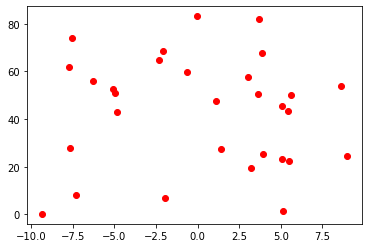

In [305]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Function
def st_fun(p: float, x: np.ndarray) -> float:
    if p < x[0]:
        y = x[1]
    else:
        y = x[2]
    return y


# Objective function
def obj_fun(x: np.ndarray, a: list[tuple[int]]) -> float:
    Y = []
    for point in a:
        y = st_fun(point[0], x)
        Y.append((y - point[1]) ** 2)
    return sum(Y)


# Minimize function
def f_minimize(a: list[tuple]) -> tuple:
    # initial guess
    x0 = np.array([1, 1, 1])
    cons = {'type': 'ineq', 'fun': lambda x: x[2] - x[1]}
    return minimize(fun=obj_fun, args=a, x0=x0, constraints=cons).x


if __name__ == '__main__':
    n = 30
    x = np.random.uniform(-10, 10, size=n)
    y = np.random.uniform(0, 100, size=n)
    idx = np.argsort(x)
    w = f_minimize([(i, j) for i, j in zip(x, y)])
    print(w)
    stepx = np.array([x.min, w[0], w[0], x.max])
    stepy = np.array([w[1], w[1], w[2], w[2]])
    plt.plot(x, y, 'ro')
    plt.plot(stepx, stepy, 'g-')
    plt.legend(['True values', 'Step function'])

In [312]:
from scipy import stats
p_value = stats.binom_test(n_w_r, n_r, p=0.43, alternative='greater')

0.0004701849845759996

In [ ]:
from scipy import stats
p_value = stats.binom_test(n_w_r, n_r, p=0.57, alternative='less')

In [ ]:
# var
print([a_d['log_reg'][index_not_mat, i, 0].var() for i in range(3)])

In [ ]:
print(p_val)

In [133]:
anova_d['log_reg_csp'][:,, 0].mean()

0.8545984216300818

In [143]:
[anova_d['log_reg_csp'][:,i, 1].mean() for i in range(3)]

[0.9872034867655757, 0.993397074297976, 0.9817646197274297]

In [144]:
[anova_d['log_reg_csp'][:,i, 1].var() for i in range(3)]

[0.0007997594763546267, 0.00023509531479550314, 0.0013444101223207322]

In [148]:
[anova_d['log_reg_r'][:,i, 1].mean() for i in range(3)]

[0.9697671845563993, 0.9290521774043123, 0.9082101037961394]

In [145]:
[anova_d['log_reg_r'][:,i, 1].var() for i in range(3)]

[0.00479279367881628, 0.038486534085381725, 0.047296991213289674]

In [146]:
[anova_d['lgbm_gr'][:,i, 1].mean() for i in range(3)]

[0.8450904469184545, 0.8202777538538351, 0.8493271403934]

In [147]:
[anova_d['lgbm_gr'][:,i, 1].var() for i in range(3)]

[0.09956531927751062, 0.12963509250244953, 0.09449409368331112]

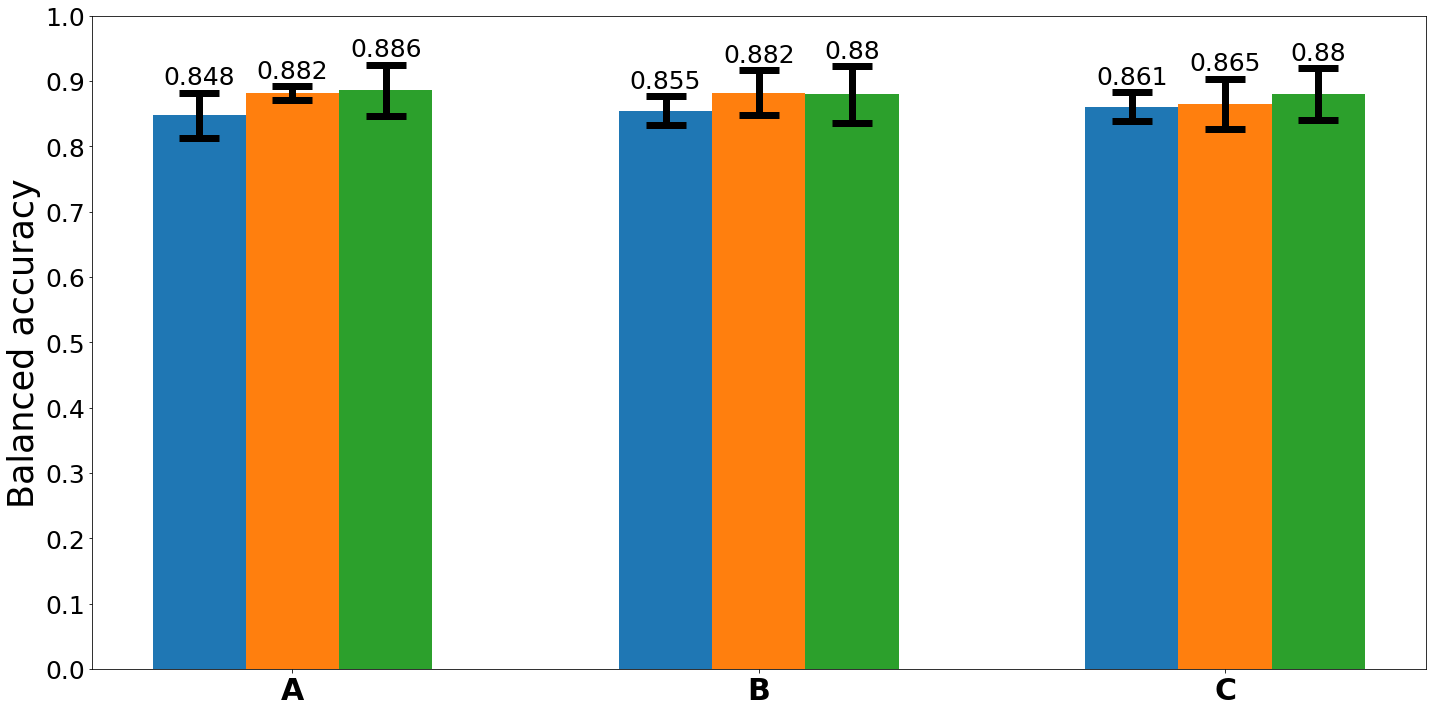

In [78]:
# bars for cross-subject group classification
fig, ax = plt.subplots(figsize=(20, 10))
labels = ['A', 'B', 'C']
x = np.arange(len(labels))
width = 0.2
rects1 = ax.bar(x - width, [anova_d['log_reg_csp'][:, i, 0].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['log_reg_csp'][:, i, 0].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Supervised')
rects2 = ax.bar(x, [anova_d['log_reg_r'][:, i, 0].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['log_reg_r'][:, i, 0].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Riemann')

rects3 = ax.bar(x + width, [anova_d['lgbm_gr'][:, i, 0].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['lgbm_gr'][:, i, 0].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Handcrafted')

ax.set_ylabel('Balanced accuracy', fontsize=35)
#ax.legend(fontsize=30)
ax.set_xticks(x, labels, fontsize=30, fontweight='semibold')
ax.set_yticks(np.arange(0, 1.1, 0.1), labels=np.arange(0, 1.1, 0.1).round(2), fontsize=25)
ax.bar_label(rects1, padding=3, fontsize=25)
ax.bar_label(rects2, padding=3, fontsize=25)
ax.bar_label(rects3, padding=3, fontsize=25)
fig.tight_layout()

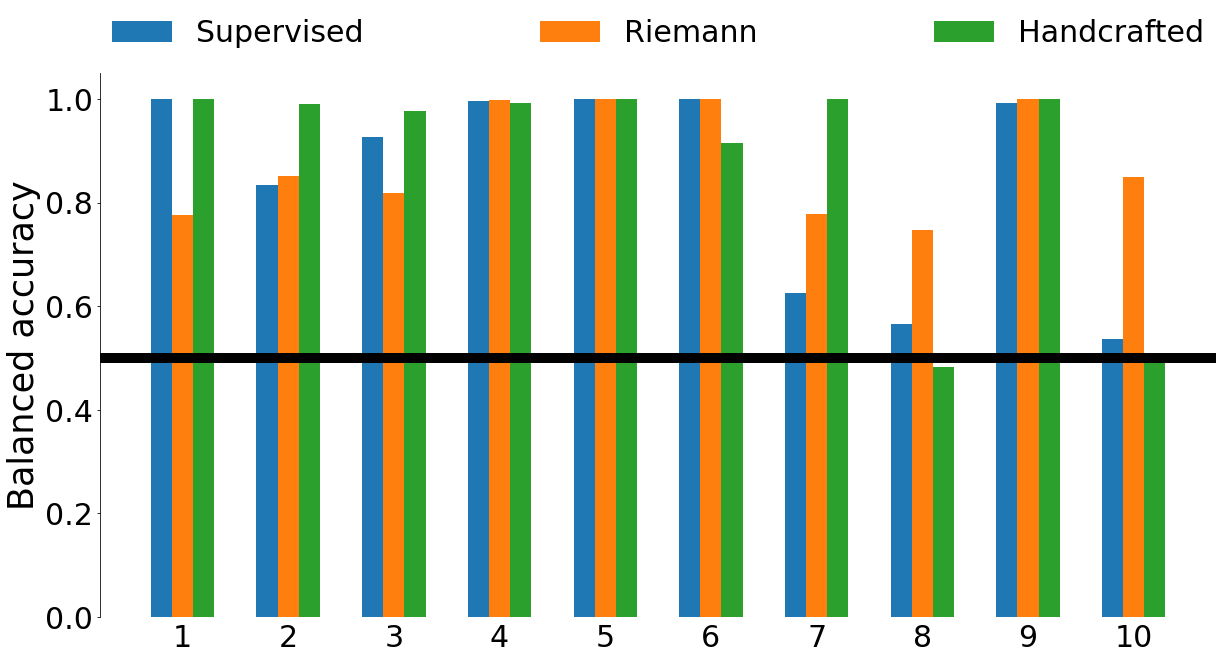

In [77]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,10))
x = np.arange(0, 10)
width = 0.2
plt.axhline(y=0.5,linewidth=10, color='black')
plt.bar(x-width, anova_d['log_reg_csp'][:, 0, 0], width=width, label='Supervised')
plt.bar(x, anova_d['log_reg_r'][:, 0, 0], width=width, label='Riemann')
plt.bar(x+width, anova_d['lgbm_gr'][:, 0, 0],  width=width, label='Handcrafted')
plt.xlabel(None)
plt.xticks(np.arange(0, 10), np.arange(1, 11), fontsize=30)
plt.ylabel('Balanced accuracy', fontsize=35)
plt.yticks(fontsize=30)
sns.despine(bottom=True)
ax.grid(False)
ax.tick_params(bottom=False, left=True)
#plt.legend(frameon=False, fontsize=15)
plt.legend(frameon=False, bbox_to_anchor=(0., 1.02, 1., .102),
                      ncol=3, mode="expand", borderaxespad=0., fontsize=30)
plt.show()

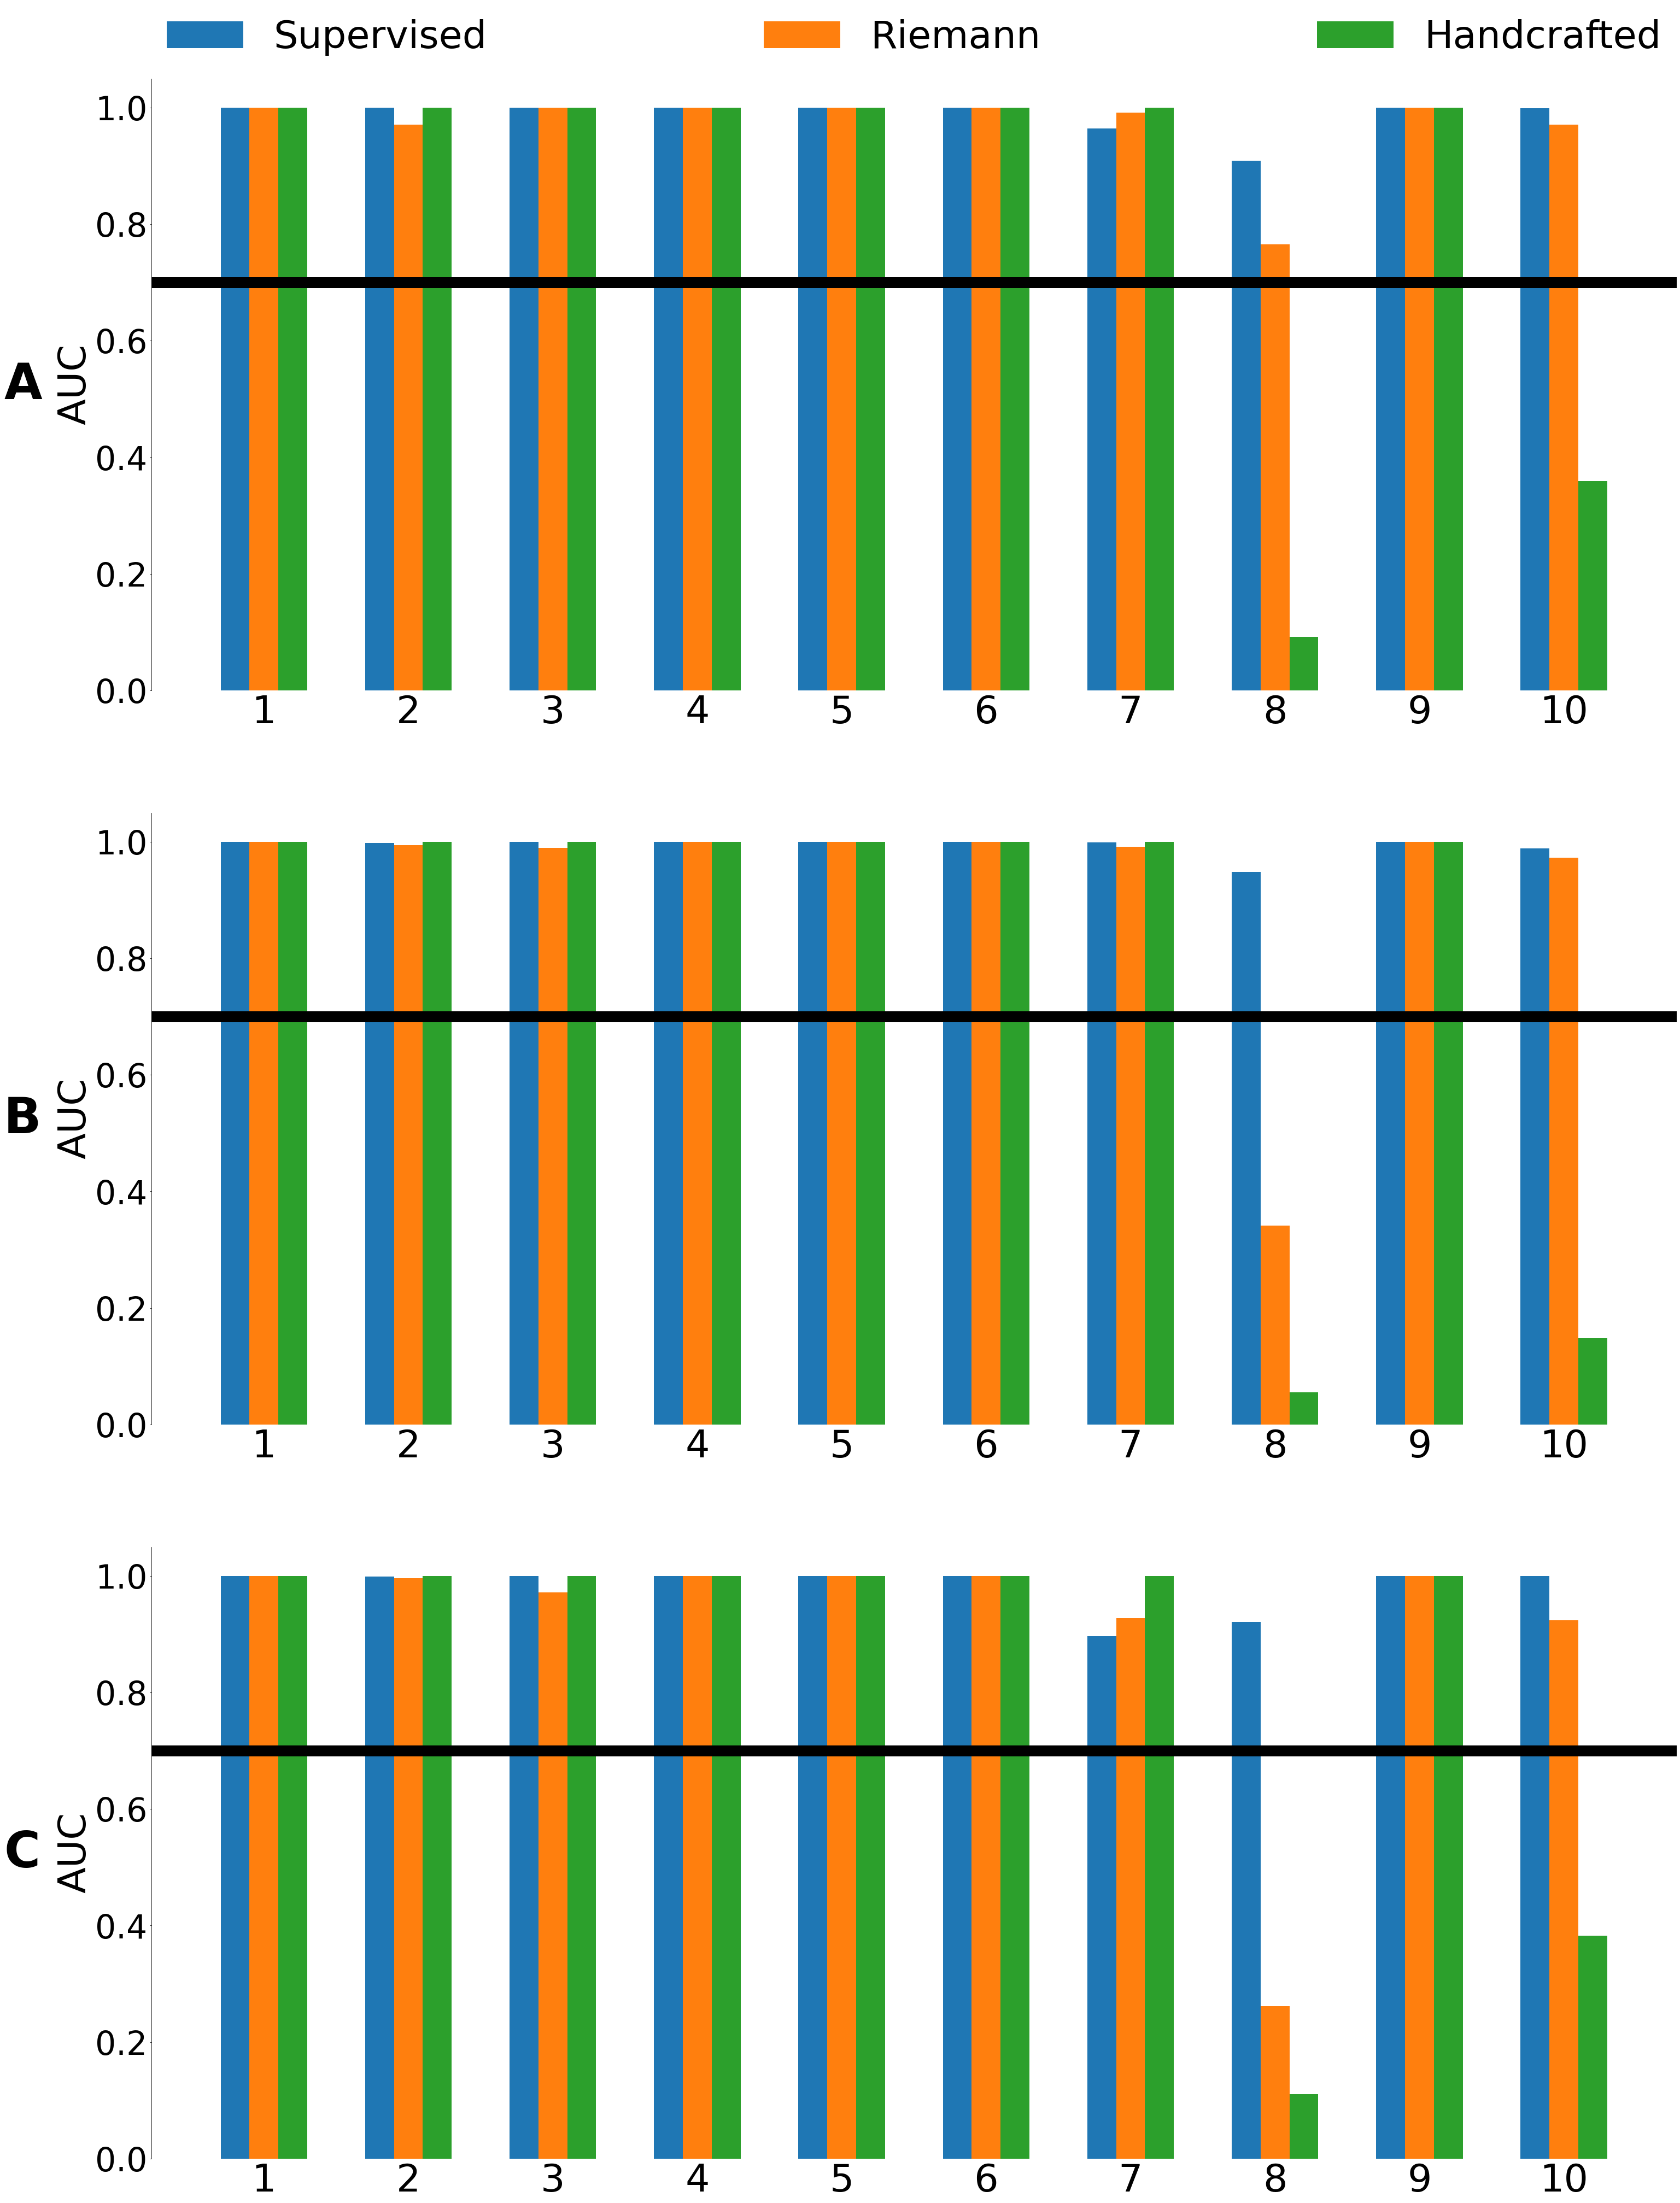

In [131]:
fig, axes = plt.subplots(nrows=3, figsize=(50,70))
x = np.arange(0, 10)
for k, name in zip(range(3), ['A', 'B', 'C']):
    axes[k].axhline(y=0.7,linewidth=20, color='black')
    axes[k].bar(x-width, anova_d['log_reg_csp'][:, k, 1], width=width, label='Supervised')
    axes[k].bar(x, anova_d['log_reg_r'][:, k, 1], width=width, label='Riemann')
    axes[k].bar(x+width, anova_d['lgbm_gr'][:, k, 1],  width=width, label='Handcrafted')
    axes[k].set_xlabel(None)
    axes[k].set_xticks(np.arange(0, 10), np.arange(1, 11), fontsize=70)
    axes[k].set_ylabel('AUC', fontsize=70)
    axes[k].set_yticks(np.arange(0, 1.1, 0.2), labels=np.arange(0, 1.1, 0.2).round(2), fontsize=60)
    sns.despine(bottom=True)
    axes[k].grid(False)
    axes[k].tick_params(bottom=False, left=True)
    #plt.legend(frameon=False, fontsize=15)
    axes[0].legend(frameon=False, bbox_to_anchor=(0., 1.02, 1., .102),
                          ncol=3, mode="expand", borderaxespad=0., fontsize=70)
    axes[k].text(-1.8, 0.5, f'{name}', fontdict={'fontsize': 90, 'fontweight': 'semibold'})

In [132]:
fig.savefig(f'Results/AUC_cross_subject_group_10.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
# save plot
fig.savefig(f'Results/accuracy_cross_subject_group_EV.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
anova_d

In [ ]:
anova_d['log_reg_r']

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

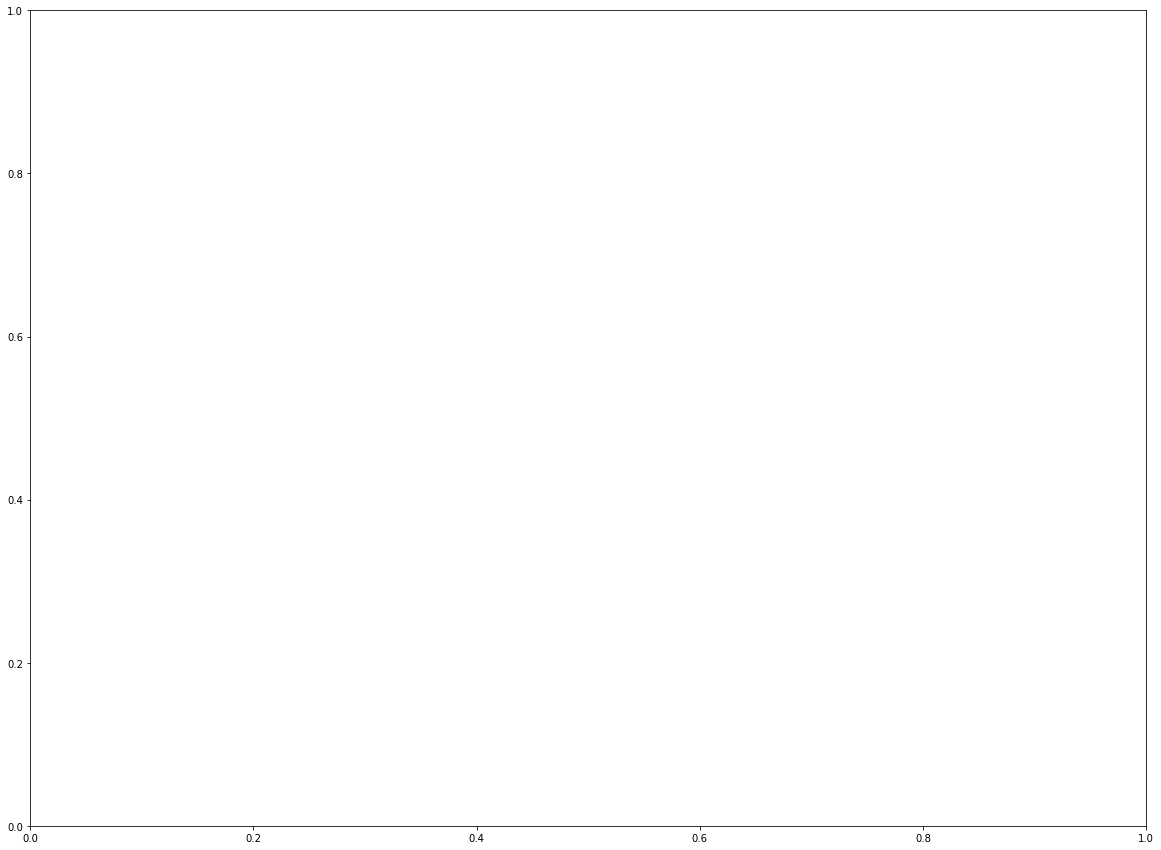

In [49]:
# bars for cross-subject group classification
fig, ax = plt.subplots(figsize=(20, 15))
labels = ['A', 'B', 'C']
x = np.arange(len(labels))
width = 0.2
ax.plot(x,0.5, color='purple', linewidth=10)
rects1 = ax.bar(x - width, [anova_d['log_reg_csp'][:, i, 1].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['log_reg_csp'][:, i, 1].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Supervised')
rects2 = ax.bar(x, [anova_d['log_reg_r'][:, i, 1].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['log_reg_r'][:, i, 1].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Riemann')

rects3 = ax.bar(x + width, [anova_d['lgbm_gr'][:, i, 1].mean().round(3) for i in range(3)], width,
                yerr=[anova_d['lgbm_gr'][:, i, 1].var()
                      for i in range(3)],
                error_kw=dict(lw=7, capsize=20, capthick=7), label='Handcrafted')

ax.set_ylabel('AUC', fontsize=35)
#ax.legend(fontsize=30)
ax.set_xticks(x, labels, fontsize=30, fontweight='semibold')
ax.set_yticks(np.arange(0, 1.1, 0.1), labels=np.arange(0, 1.1, 0.1).round(2), fontsize=25)
ax.bar_label(rects1, padding=3, fontsize=25)
ax.bar_label(rects2, padding=3, fontsize=25)
ax.bar_label(rects3, padding=3, fontsize=25)
fig.tight_layout()

In [ ]:
index mat

In [ ]:
# save plot
fig.savefig(f'Results/auc_cross_subject_group_EV.png', format='png', bbox_inches='tight', dpi=300)

In [ ]:
# Wilcoxon signed-rank test
p_val = []
for c1, a in enumerate(
        zip([a_d['log_reg_gr'][:, i, 0] for i in range(3)], [a_d['lgbm_gr'][:, i, 0] for i in range(3)])):
    _, p = stats.wilcoxon(a[0], a[1])
    p_val.append(p)

In [ ]:
print(p_val)

In [ ]:
# bars for cross-subject tasks classification
l_fig = []
for gr in [0, 1]:
    fig, ax = plt.subplots(figsize=(20, 15))
    labels = ['A', 'B', 'C']
    x = np.arange(len(labels))
    width = 0.35
    rects1 = ax.bar(x - width / 2, [a_d['log_reg_gr_t'][gr, :, i, 0].mean() for i in range(3)], width,
                    yerr=[a_d['log_reg_gr_t']
                          [gr, :, i, 0].var() for i in range(3)], error_kw=dict(lw=7, capsize=20, capthick=7),
                    label='Logistic regression')
    rects2 = ax.bar(x + width / 2, [a_d['lgbm_gr_t'][gr, :, i, 0].mean() for i in range(3)], width,
                    yerr=[a_d['lgbm_gr_t']
                          [gr, :, i, 0].var() for i in range(3)], error_kw=dict(lw=7, capsize=20, capthick=7),
                    label='LightGBM')
    ax.set_ylabel('Balanced accuracy', fontsize=35)
    ax.legend(fontsize=30)
    ax.set_xticks(x, labels, fontsize=30, fontweight='semibold')
    ax.set_yticks(np.arange(0, 1.1, 0.1), labels=np.arange(0, 1.1, 0.1).round(2), fontsize=25)
    ax.bar_label(rects1, padding=3, fontsize=25)
    ax.bar_label(rects2, padding=3, fontsize=25)
    fig.tight_layout()
    l_fig.append(fig)

In [ ]:
# save plots
for fig, name in zip(l_fig, ['math', 'not_math']):
    fig.savefig(f'Results/accuracy_cross_subject_tasks_{name}.png', format='png', bbox_inches='tight', dpi=300)

In [165]:
# Wilcoxon signed-rank test
p_val = np.zeros((1,3))
for c2, a in enumerate(zip([anova_d['log_reg_csp'][:, i, 1] for i in range(3)],
                           [anova_d['lgbm_gr'][:, i, 1] for i in range(3)])):
    _, p = stats.wilcoxon(a[0], a[1])
    p_val[0][c2] = p

In [166]:
print(p_val)

[[0.28504941 0.86577237 0.68583043]]


In [ ]:
# var
print([a_d['log_reg_gr_t'][1, :, i, 0].var() for i in range(3)])

In [168]:
a = [1,2]
b = a.copy()
print(id(a),id(b))

140627039545664 140626687645760


In [204]:
def get_card_count(n, k, cards) -> int:
    result = sum(cards[:k])
    i, j = k-1, -1
    sum_1 = result
    while i>=0:
        sum_1 += cards[j] - cards[i]
        result = max(result, sum_1)
        i -= 1
        j -= 1
    return result

n = 7
k = 4
cards = [5, 8, 2, 1, 3, 4, 11]

print(get_card_count(n, k, cards))

28


In [205]:
cards // 2

TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [ ]:
def get_card_count(n, k, cards) -> int:
    result = sum(cards[:k])
    i, j = k-1, n-1
    while i>0:
        result = max(result, result-cards[i]+cards[j])
        i -= 1
        j -= 1
    return result


n = int(input())
k = int(input())
cards = list(map(int, input().split()))

print(get_card_count(n, k, cards))

In [207]:
for n in []:
    print('a')

In [209]:
a = {}
sum(a.values())

0

In [ ]:
def get_number_of_good_pairs(numbers) -> int:
    numbers = [n%200 if n>200 else n%200 for n in numbers]
    counter = {}
    for n in numbers:
        if n in counter:
           counter[n] += 1
        else:
           counter[n] = 0
    return sum(counter.values())

In [213]:
def get_number_of_good_pairs(numbers) -> int:
    numbers = [n%200 if n>=200 else n for n in numbers]
    counter = {}
    for n in numbers:
        if n in counter:
           counter[n] += 1
        else:
           counter[n] = 1
    return sum([int(n*(n-1)/2) for n in counter.values()])

In [214]:
numbers = [203, 404, 204, 200, 403]
get_number_of_good_pairs(numbers)

2

In [ ]:
def normalize(text):
    i = 0
    s, e, counter = 0, 0, 0
    while i < len(text)-1:
          if text[i] == ' ' and text[i+1] == ' ':
            s = i+1
            while e < len(text) and text[s+e] == ' ':
                  e += 1
            if text[s+e] == ' ' and s + e == len(text) -1:
               counter += e
               break
            else:
               counter += 1
            text[s], text[s+e] = text[s+e], text[s]
            s, e = 0, 0
          i += 1

    return text[:len(text)-counter]